In [4]:
import zipfile

# Specify the path to your ZIP file
zip_file_path = 'Yoga Postures Dataset.zip'

# Specify the directory where you want to extract the contents
extracted_dir = 'yoga_model'

# Create a ZipFile object and open the ZIP file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the ZIP file to the specified directory
    zip_ref.extractall(extracted_dir)

# The contents of the ZIP file are now extracted to 'extracted_dir'

In [10]:
#venaam
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Set the path to the directory containing your labeled yoga pose images
image_dir = 'yoga_model'

# Define the dimensions for the images
img_width, img_height = 64, 64

# Define the number of classes (yoga poses)
num_classes = 10

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    data_format='channels_last',
)

# Load and preprocess images from the specified directory with class labels
image_data = datagen.flow_from_directory(
    image_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # This is for multi-class classification
    shuffle=True,
)

# Define the Generator model
def build_generator():
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([noise_input, label_input])
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(img_width * img_height * 3, activation='tanh')(x)
    generated_image = Reshape((img_width, img_height, 3))(x)
    return Model([noise_input, label_input], generated_image)

# Define the Discriminator model
def build_discriminator():
    image_input = Input(shape=(img_width, img_height, 3))
    label_input = Input(shape=(num_classes,))
    x = Flatten()(image_input)
    x = Concatenate()([x, label_input])
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    validity = Dense(1, activation='sigmoid')(x)
    return Model([image_input, label_input], validity)

# Create and compile the GAN model
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

discriminator.trainable = False  # Freeze the Discriminator during GAN training
gan_input_noise = Input(shape=(100,))
gan_input_label = Input(shape=(num_classes,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])
gan = Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Training loop for GAN
epochs = 10000
batch_size = 32

# Define the save interval
save_interval = 100  # Save generated images every 100 epochs

def save_generated_images(epoch):
    r, c = 5, 5  # Number of rows and columns of generated images
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.eye(num_classes)[np.arange(r * c) % num_classes]
    generated_images = generator.predict([noise, labels])
    generated_images = 0.5 * generated_images + 0.5  # Scale back to [0, 1]
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(generated_images[cnt])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.close()

for epoch in range(epochs):
    # Train Discriminator
    real_images, real_labels = image_data.next()
    real_labels = np.eye(num_classes)[np.argmax(real_labels, axis=1)]  # Convert one-hot to label
    real_labels = real_labels.reshape((-1, num_classes))

    fake_labels = np.eye(num_classes)[np.random.randint(0, num_classes, batch_size)]  # Generate random labels
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator.predict([noise, fake_labels])

    d_loss_real = discriminator.train_on_batch([real_images, real_labels], np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([generated_images, fake_labels], np.zeros((batch_size, 1)))

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.eye(num_classes)[np.random.randint(0, num_classes, batch_size)]  # Generate random labels

    g_loss = gan.train_on_batch([noise, valid_labels], np.ones((batch_size, 1)))

    # Print progress
    print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # Save generated images at specific intervals
    if epoch % save_interval == 0:
        save_generated_images(epoch)


Found 11344 images belonging to 1 classes.
Epoch 0/10000 [D loss: 0.7391758263111115 | D accuracy: 53.125] [G loss: 0.8200466632843018]


KeyboardInterrupt: 

In [8]:
# Training loop for GAN
#venaam
#modified by sk
epochs = 10000
batch_size = 32

# ...

for epoch in range(epochs):
    # Train Discriminator
    real_images, real_labels = image_data.next()
    real_labels = np.eye(num_classes)[np.argmax(real_labels, axis=1)]  # Convert one-hot to label
    real_labels = real_labels.reshape((-1, num_classes))

    # Ensure that real_images and real_labels have the same batch size
    real_images = real_images[:batch_size]
    real_labels = real_labels[:batch_size]

    fake_labels = np.eye(num_classes)[np.random.randint(0, num_classes, batch_size)]  # Generate random labels
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator.predict([noise, fake_labels])

    d_loss_real = discriminator.train_on_batch([real_images, real_labels], np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([generated_images, fake_labels], np.zeros((batch_size, 1)))

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.eye(num_classes)[np.random.randint(0, num_classes, batch_size)]  # Generate random labels

    g_loss = gan.train_on_batch([noise, valid_labels], np.ones((batch_size, 1)))

    # Print progress
    print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # Save generated images at specific intervals
    if epoch % save_interval == 0:
        save_generated_images(epoch)


Epoch 0/10000 [D loss: 0.17214780673384666 | D accuracy: 100.0] [G loss: 1.9454426765441895]
Epoch 1/10000 [D loss: 0.18083560466766357 | D accuracy: 100.0] [G loss: 2.033548355102539]
Epoch 2/10000 [D loss: 0.13903159275650978 | D accuracy: 100.0] [G loss: 2.729410171508789]
Epoch 3/10000 [D loss: 0.5498755574226379 | D accuracy: 64.0625] [G loss: 0.8486023545265198]
Epoch 4/10000 [D loss: 0.2544212352950126 | D accuracy: 87.5] [G loss: 1.7636525630950928]
Epoch 5/10000 [D loss: 0.17283201217651367 | D accuracy: 100.0] [G loss: 2.403568983078003]
Epoch 6/10000 [D loss: 0.6897063851356506 | D accuracy: 62.5] [G loss: 0.5502333045005798]
Epoch 7/10000 [D loss: 0.4847301668487489 | D accuracy: 59.375] [G loss: 0.9611845016479492]
Epoch 8/10000 [D loss: 0.17658634390681982 | D accuracy: 100.0] [G loss: 1.6703932285308838]
Epoch 9/10000 [D loss: 0.26009756326675415 | D accuracy: 98.4375] [G loss: 1.5247211456298828]
Epoch 10/10000 [D loss: 0.20622415840625763 | D accuracy: 100.0] [G loss: 

ValueError: Data cardinality is ambiguous:
  x sizes: 16, 16
  y sizes: 32
Make sure all arrays contain the same number of samples.

In [3]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
generator.save('your_generator_model.h5')

# Load the trained generator model
generator = load_model('your_generator_model.h5') 
generator.compile(loss='binary_crossentropy', optimizer='adam')# Replace 'your_generator_model.h5' with the actual file path

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and save images for specific pose labels
def generate_images_for_labels(num_images, labels):
    for label in labels:
        label_one_hot = np.zeros((num_images, num_classes))
        label_idx = class_labels.index(label)
        label_one_hot[:, label_idx] = 1
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5

        for i in range(num_images):
            img = generated_images[i]
            plt.imshow(img)
            plt.axis('off')
            plt.savefig(f'generated_images/{label}_{i + 1}.png')
            plt.close()  # Close the figure after saving

# Generate and save images for specific pose labels
generate_images_for_labels(num_images_to_generate, class_labels)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
# Load the saved model
generator = load_model('your_generator_model.h5') 
# Compile the model manually
generator.compile(loss='binary_crossentropy', optimizer='adam')  # Replace with your desired loss and optimizer

# Now you can use the model for prediction or generation


# Load the trained generator model
 # Replace 'your_generator_model.h5' with the actual file path

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and display images for specific pose labels
def generate_and_display_images(num_images, labels):
    plt.figure(figsize=(10, 10))
    for label in labels:
        if label not in class_labels:
            print(f"Label '{label}' not found in class_labels.")
            continue

        label_idx = class_labels.index(label)
        label_one_hot = np.zeros((num_images, num_classes))
        label_one_hot[:, label_idx] = 1
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5

        for i in range(num_images):
            plt.subplot(num_images, len(labels), i * len(labels) + 1 + label_idx)
            plt.imshow(generated_images[i])
            plt.axis('off')

    plt.show()

# Generate and display images for specific pose labels
generate_and_display_images(num_images_to_generate, class_labels)


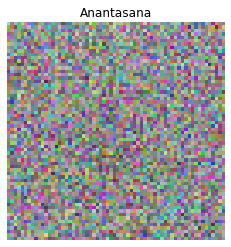

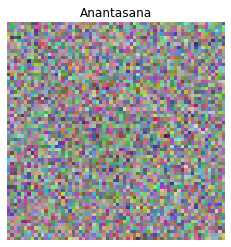

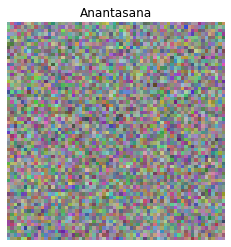

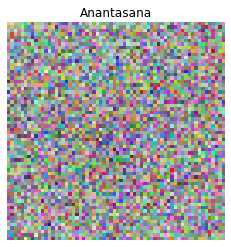

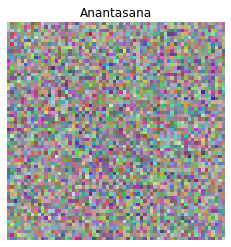

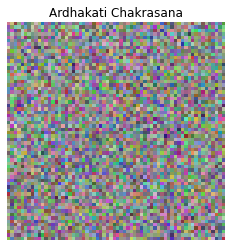

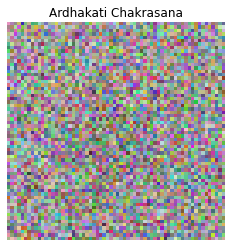

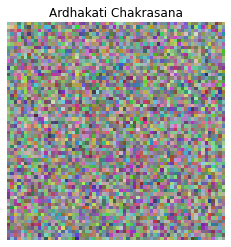

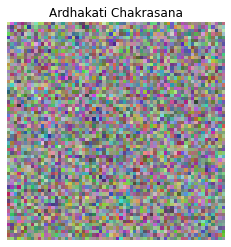

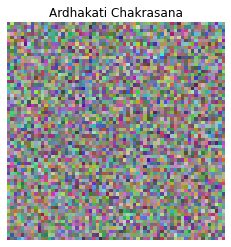

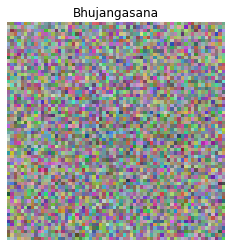

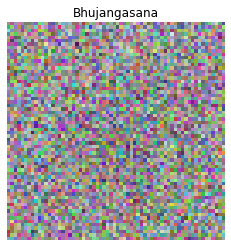

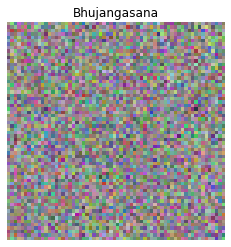

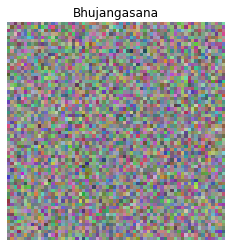

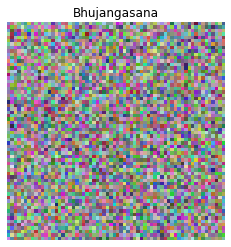

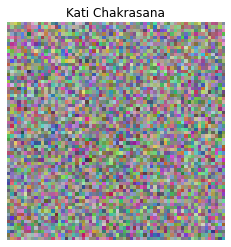

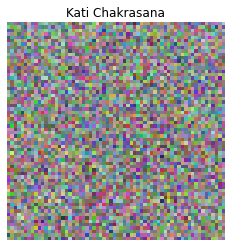

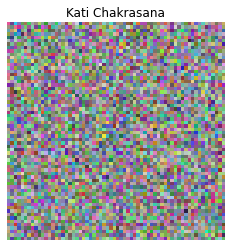

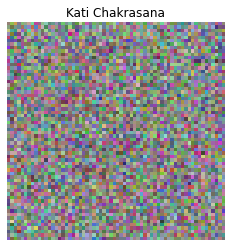

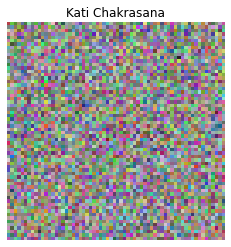

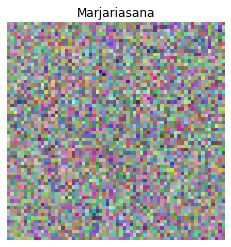

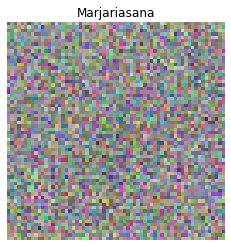

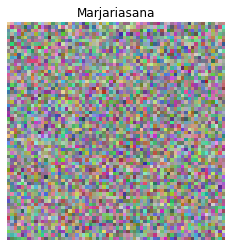

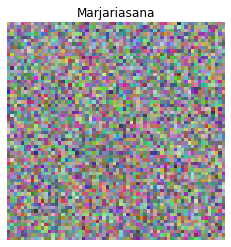

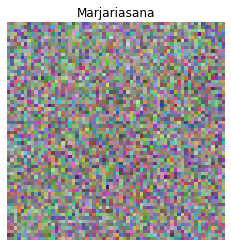

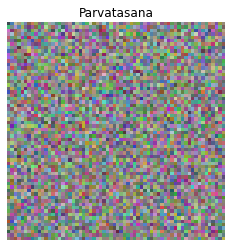

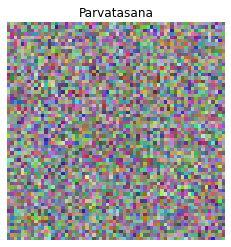

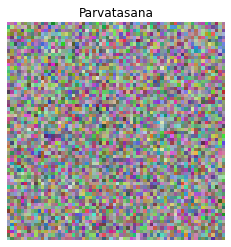

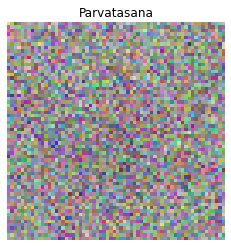

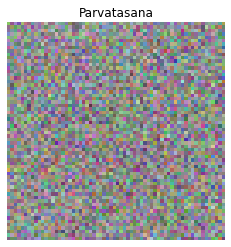

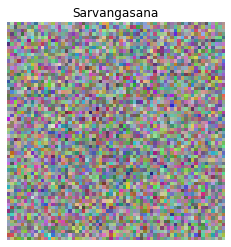

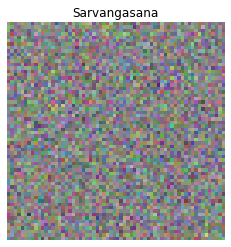

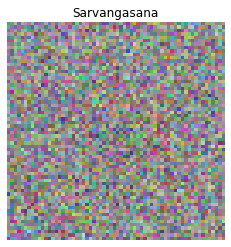

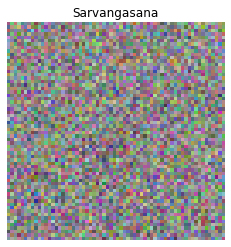

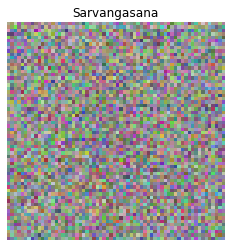

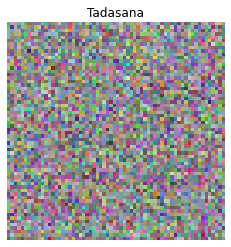

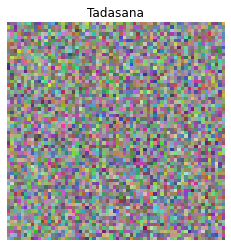

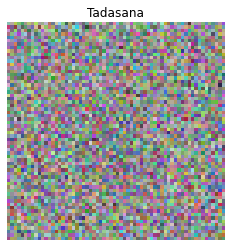

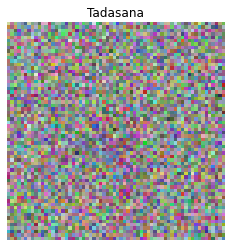

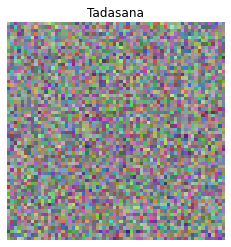

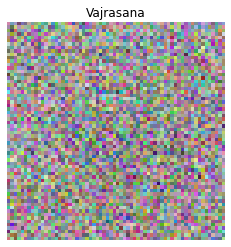

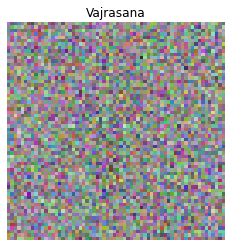

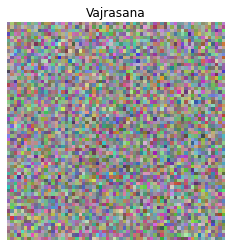

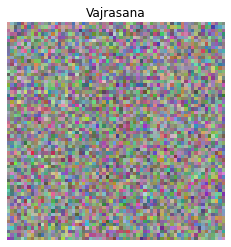

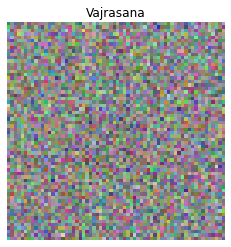

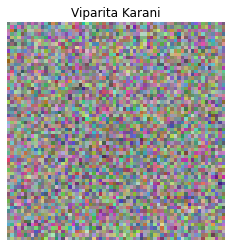

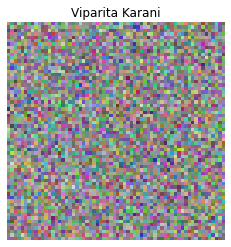

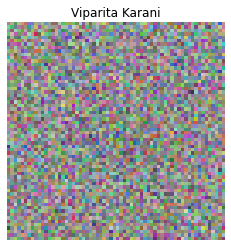

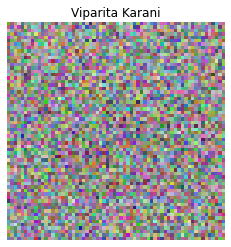

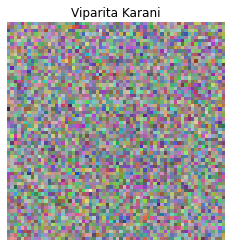

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained generator model
generator = load_model('your_generator_model.h5')
generator.compile(loss='binary_crossentropy', optimizer='adam')# Replace 'your_generator_model.h5' with the actual file path

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and display images for specific pose labels
def generate_and_display_images(num_images, labels):
    for label in labels:
        if label not in class_labels:
            print(f"Label '{label}' not found in class_labels.")
            continue

        label_idx = class_labels.index(label)
        label_one_hot = np.zeros((num_images, num_classes))
        label_one_hot[:, label_idx] = 1
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5

        for i in range(num_images):
            plt.figure()
            plt.imshow(generated_images[i])
            plt.axis('off')
            plt.title(label)
            plt.show()

# Generate and display images for specific pose labels
generate_and_display_images(num_images_to_generate, class_labels)


In [5]:
from tensorflow.keras.optimizers import Adam  # Import the optimizer you used during training

# Load the saved model
generator = load_model('your_generator_model.h5')

# Define the optimizer and compile the model manually
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)  # Replace with your specific optimizer and learning rate
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Now the model is compiled and ready for use


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the Generator model architecture
def build_generator():
    # ... (define the architecture as you did before)

# Load just the weights of the generator
generator = build_generator()
generator.load_weights('your_generator_model.h5')

# Compile the generator manually
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Now you can use the generator for generating images


IndentationError: expected an indented block (Temp/ipykernel_8624/2086690711.py, line 12)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the pre-trained yoga pose classification model
pose_classifier = load_model('your_generator_model.h5')  # Replace with the actual model file

# Load and preprocess an input image
img_path = 'download.jpeg'  # Replace with the path to your input image
img = image.load_img(img_path, target_size=(64, 64))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values to [0, 1]

# Predict the yoga pose from the input image
predictions = pose_classifier.predict(img)

# Get the predicted pose label
predicted_pose_label = class_labels[np.argmax(predictions)]

print(f"Predicted Yoga Pose: {predicted_pose_label}")


ValueError: in user code:

    File "C:\Users\swathika\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\swathika\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\swathika\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\swathika\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\swathika\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\swathika\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 64, 64, 3) dtype=float32>]


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Set the path to the directory containing your labeled yoga pose images
image_dir = 'yoga_model'

# Define the dimensions for the images
img_width, img_height = 64, 64

# Define the number of classes (yoga poses)
num_classes = 10

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    data_format='channels_last',
)

# Load and preprocess images from the specified directory with class labels
image_data = datagen.flow_from_directory(
    image_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # This is for multi-class classification
    shuffle=True,
)

# Define the Generator model architecture
def build_generator():
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([noise_input, label_input])
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(img_width * img_height * 3, activation='tanh')(x)
    generated_image = Reshape((img_width, img_height, 3))(x)
    return Model([noise_input, label_input], generated_image)

# Load just the weights of the generator
generator = build_generator()
generator.load_weights('your_generator_model.h5')

# Compile the generator manually
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and save images for specific pose labels
def generate_images_for_labels(num_images, labels):
    for label in labels:
        label_one_hot = np.zeros((num_images, num_classes))  # Modify the shape
        label_idx = class_labels.index(label)
        label_one_hot[:, label_idx] = 1  # Set the one-hot encoding for the specified label
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5  # Scale back to [0, 1]

        for i in range(num_images):
            img = generated_images[i]
            plt.imshow(img)
            plt.axis('off')
            plt.savefig(f'generated_images/{label}_{i + 1}.png')
            plt.clf()  # Clear the plot for the next image

# Generate and save images for specific pose labels
generate_images_for_labels(num_images_to_generate, class_labels)


Found 11344 images belonging to 1 classes.


<Figure size 432x288 with 0 Axes>

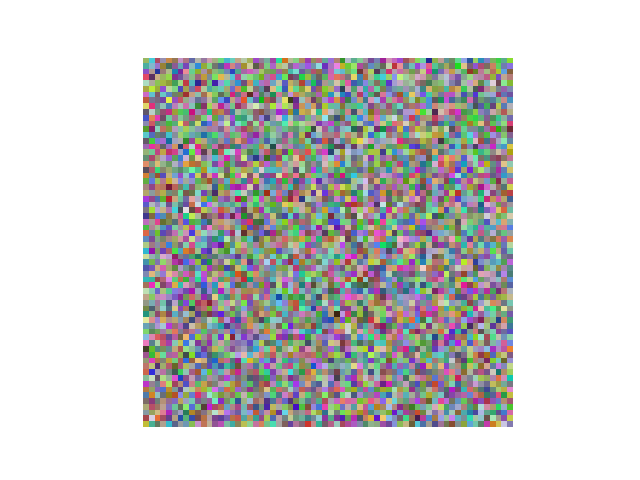

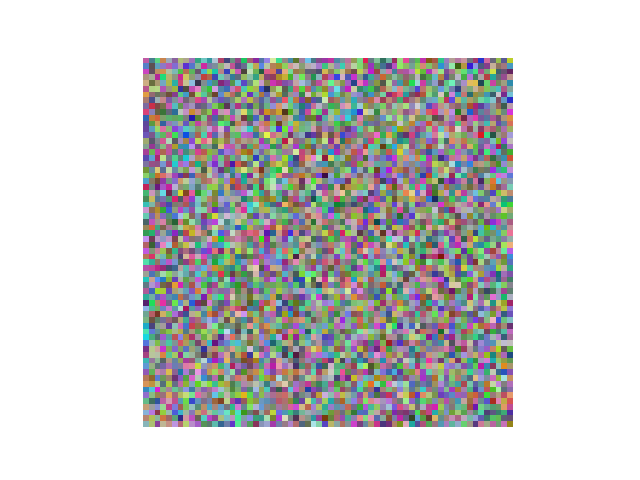

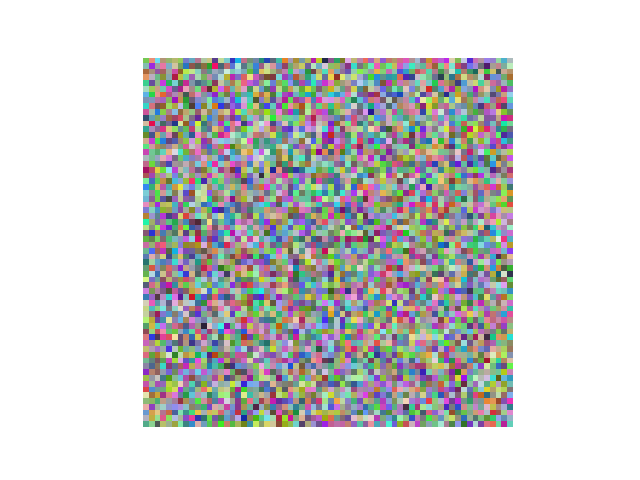

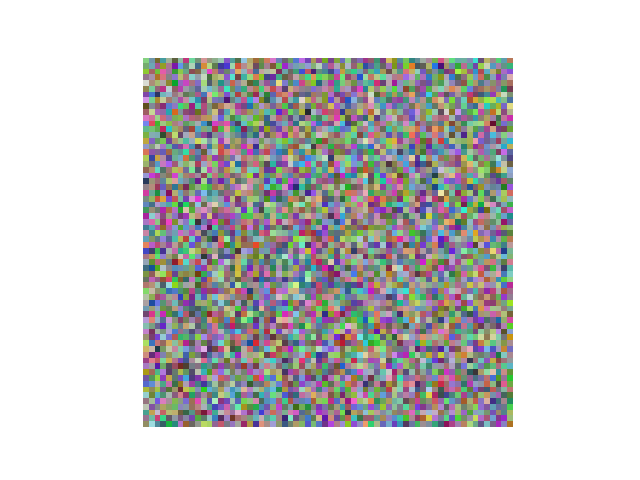

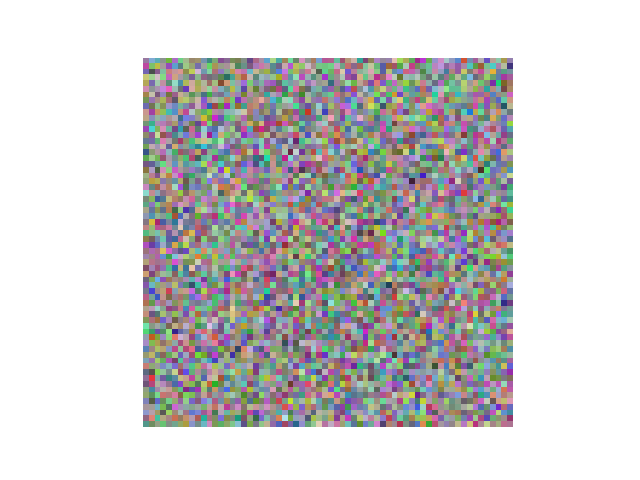

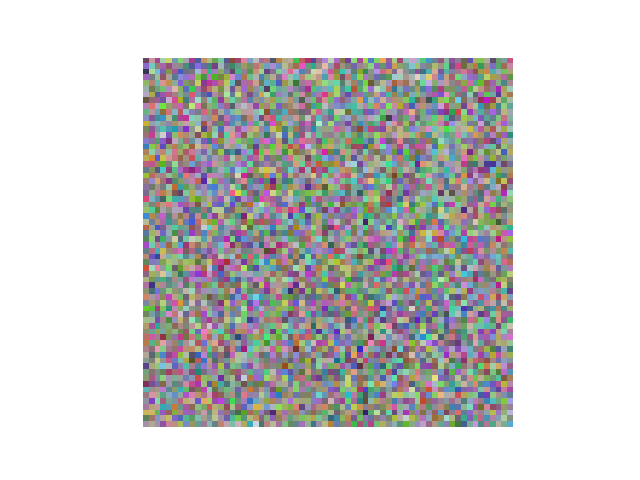

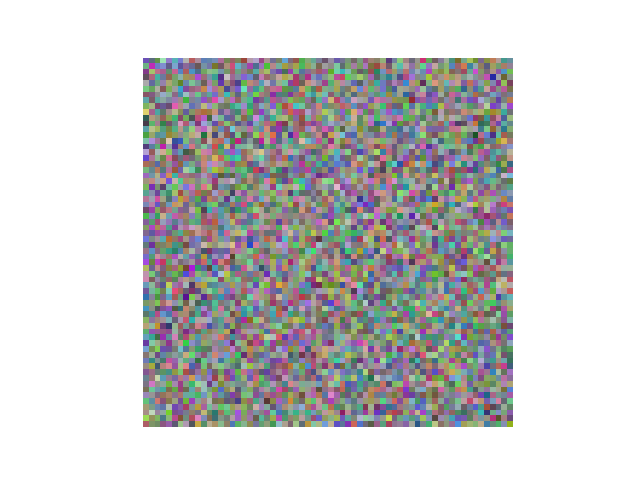

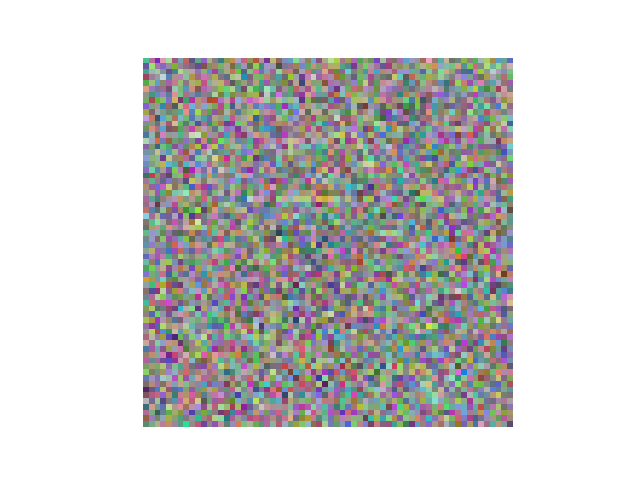

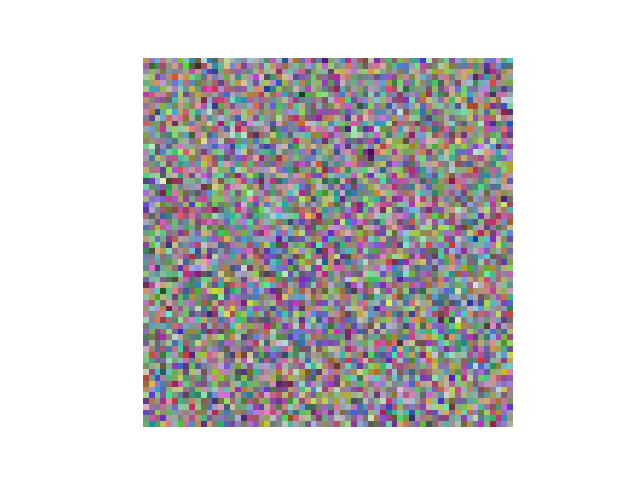

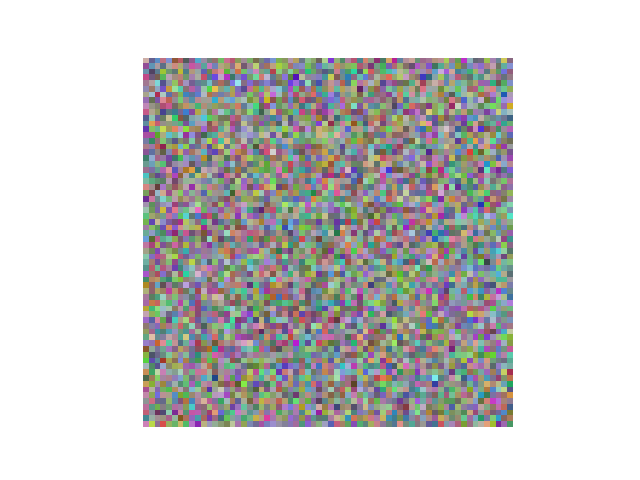

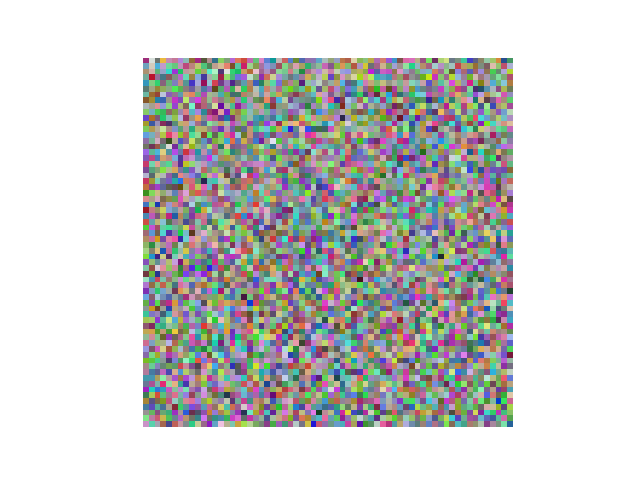

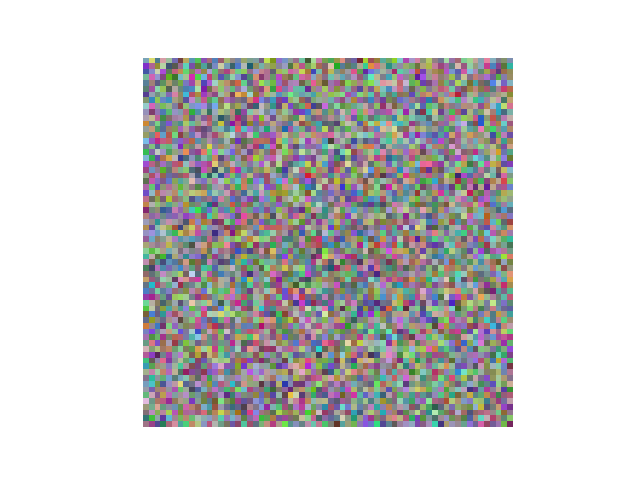

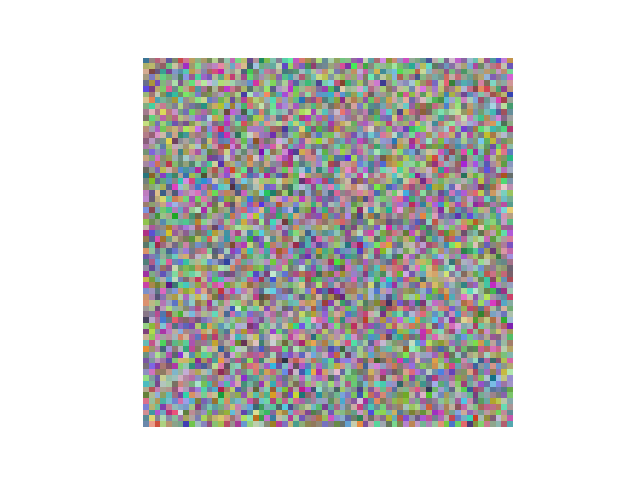

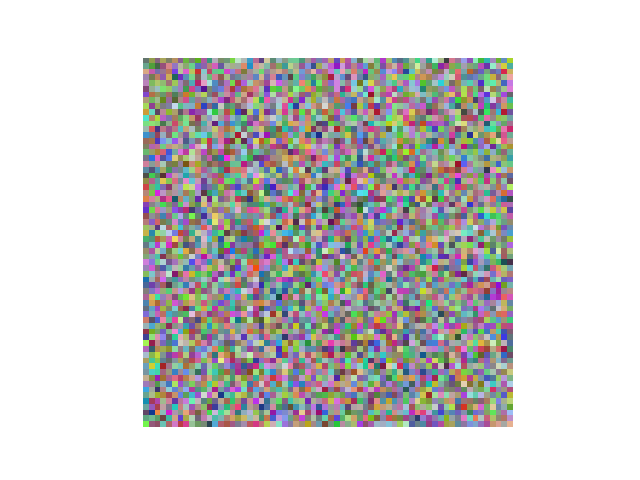

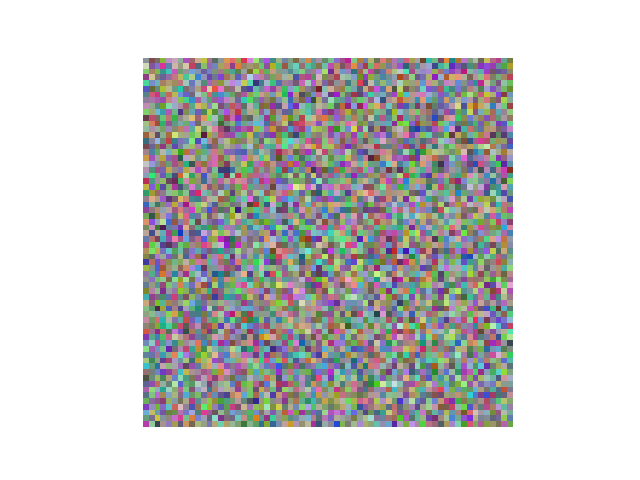

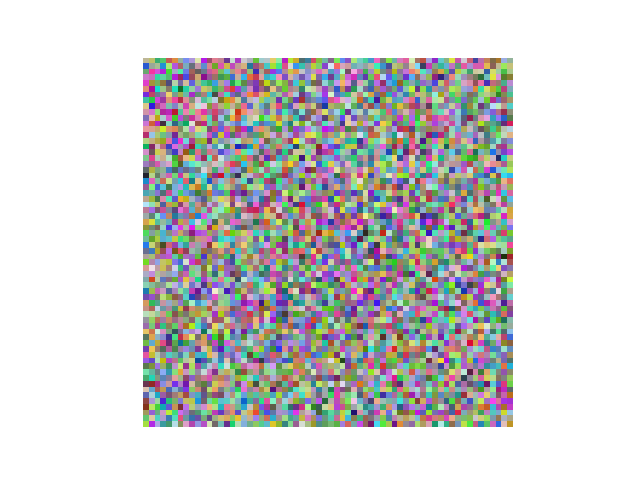

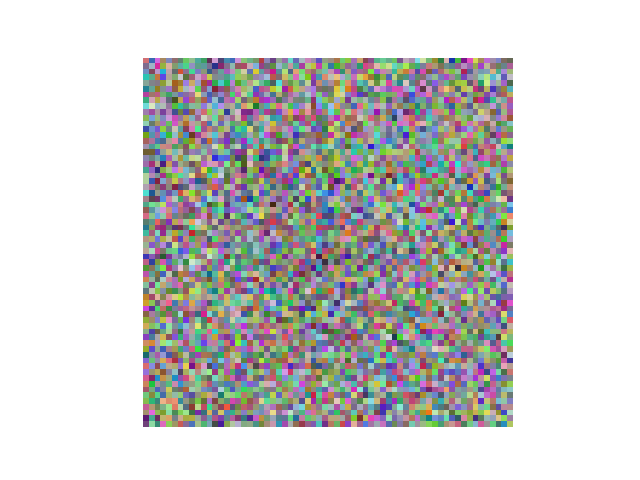

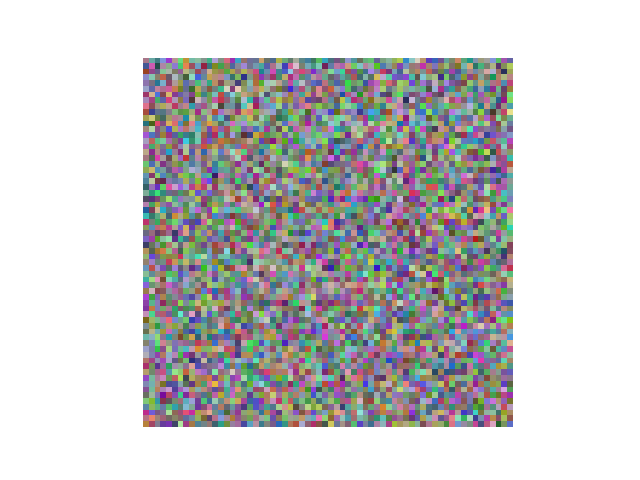

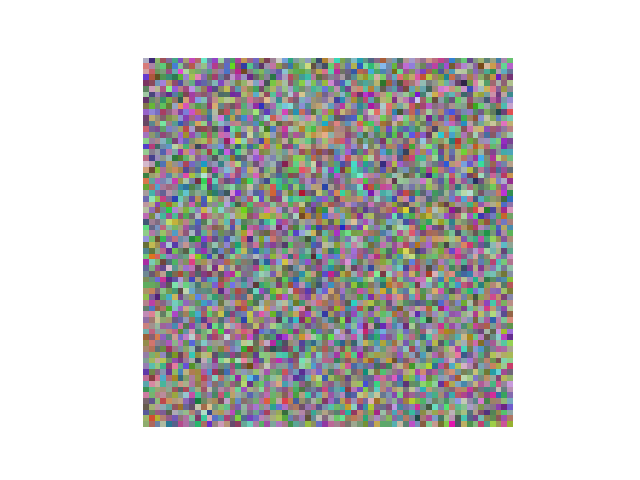

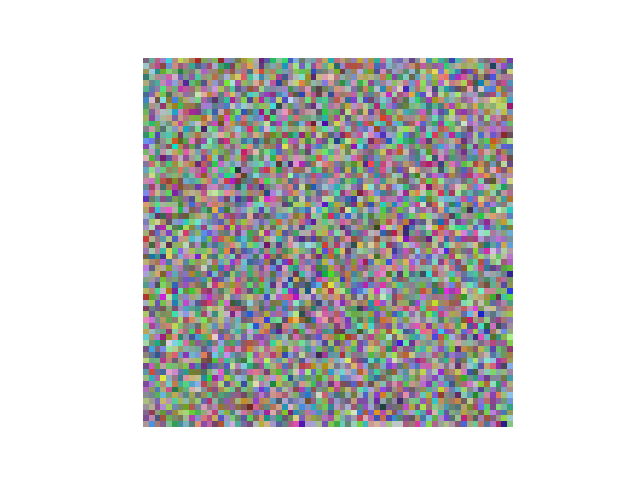

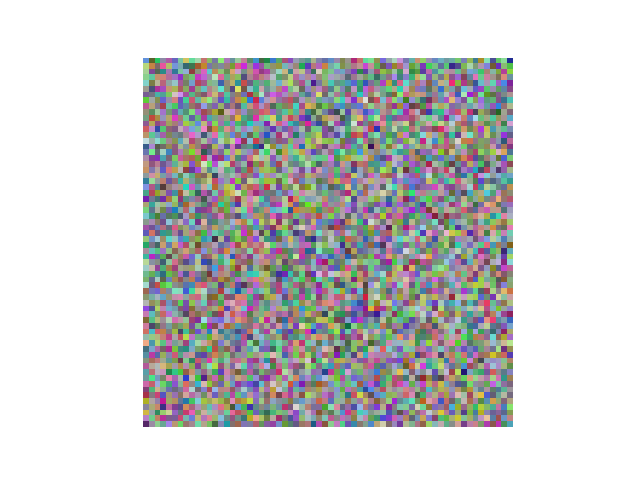

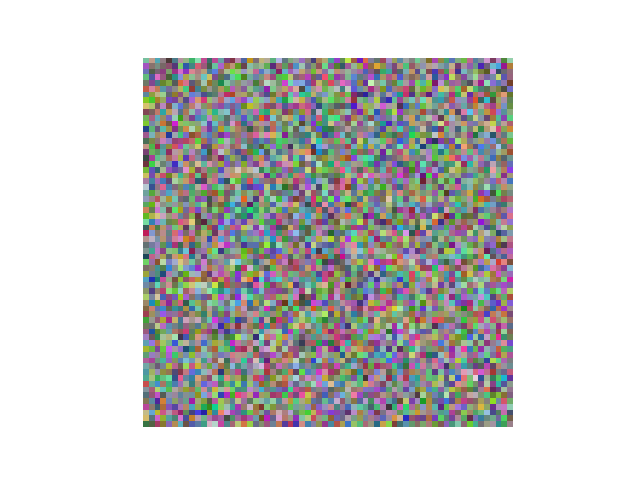

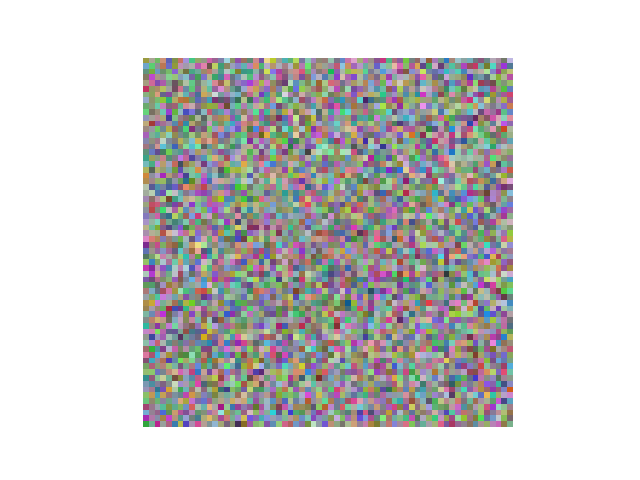

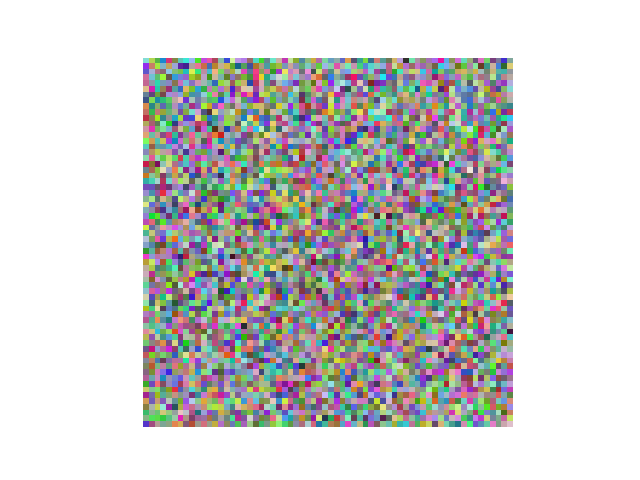

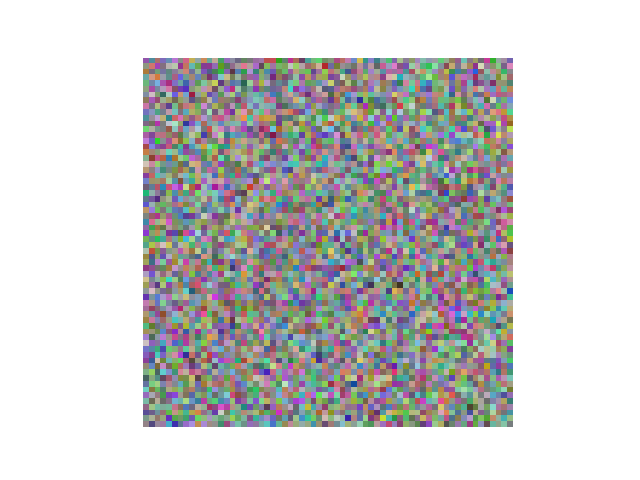

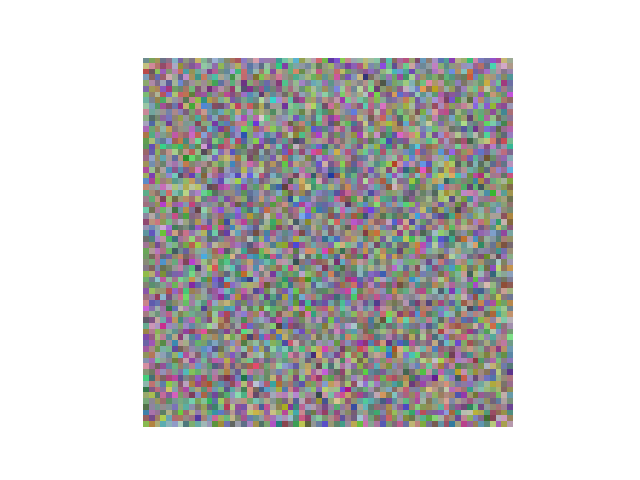

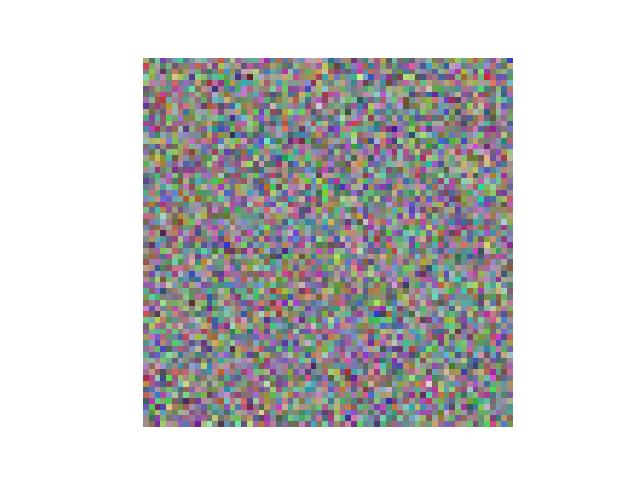

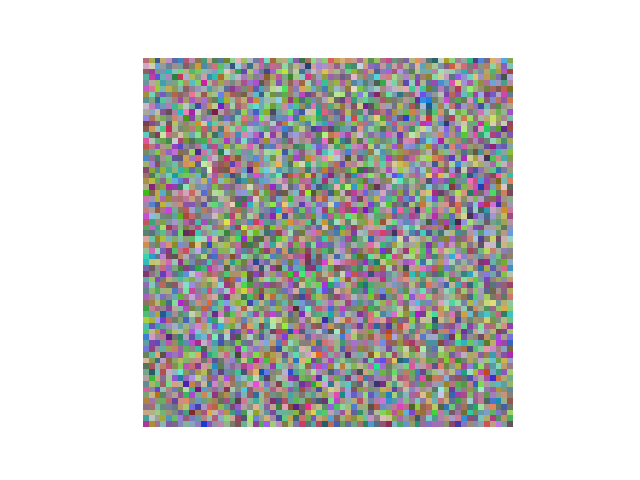

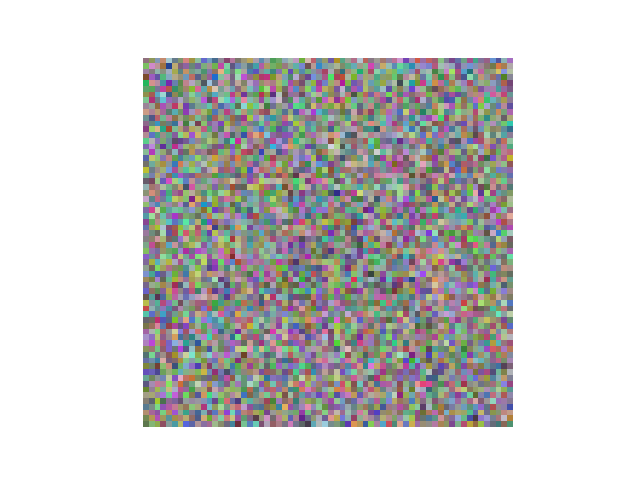

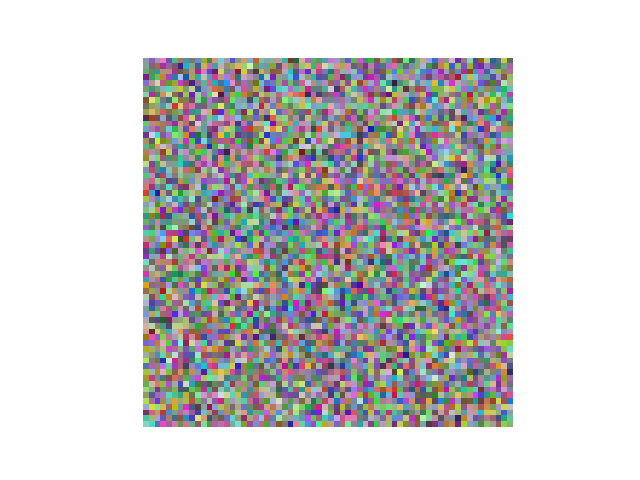

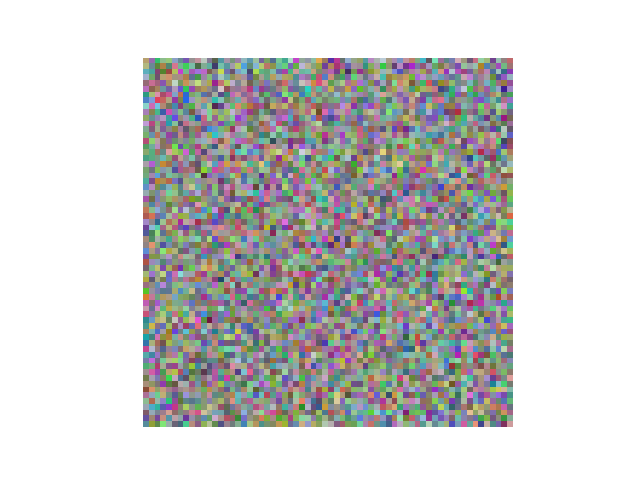

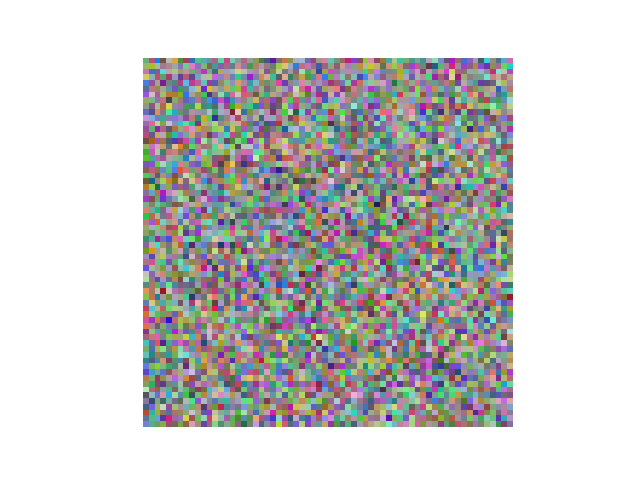

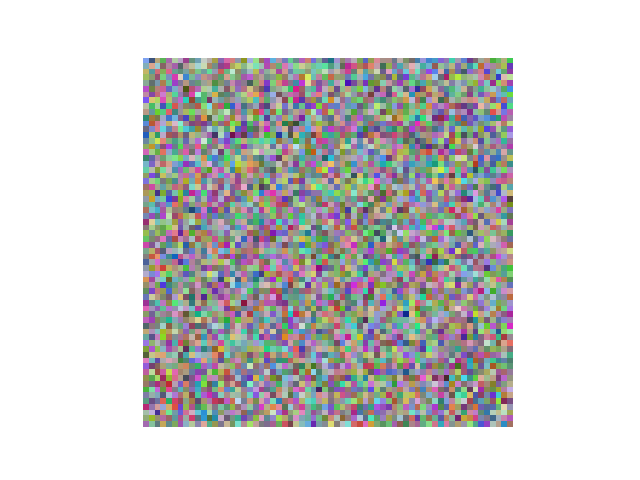

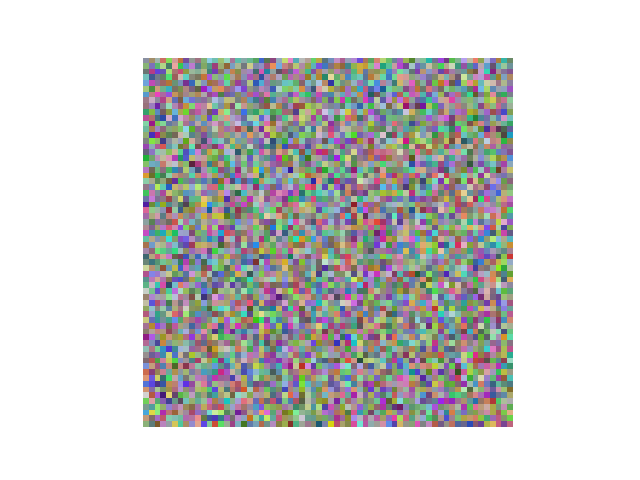

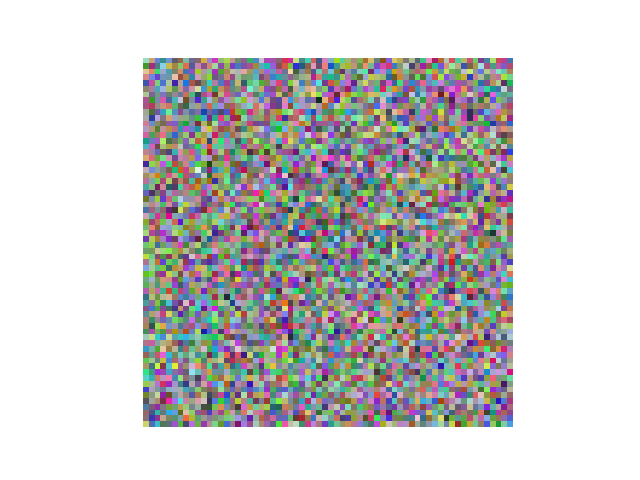

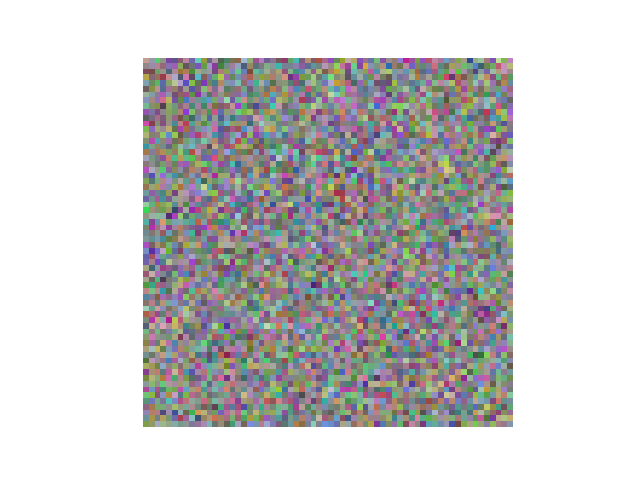

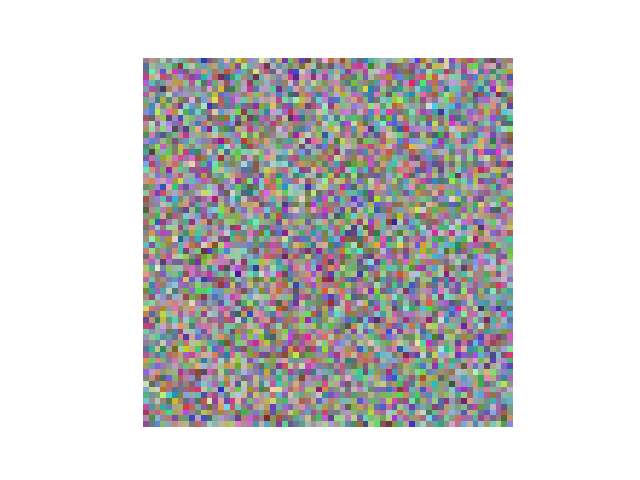

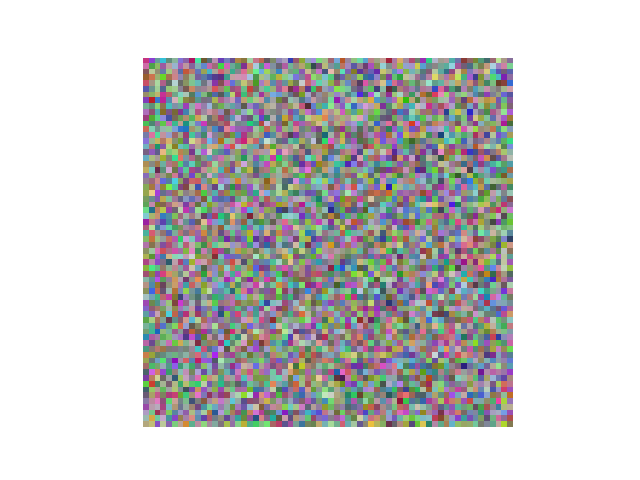

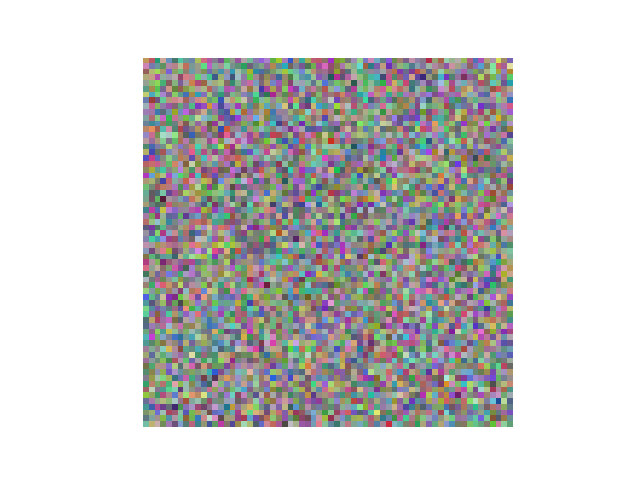

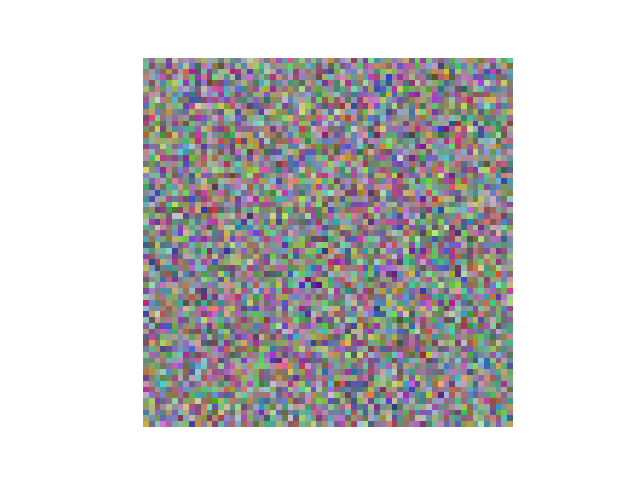

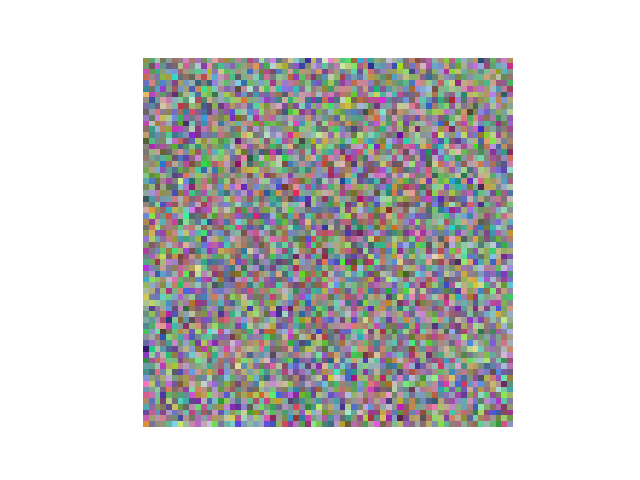

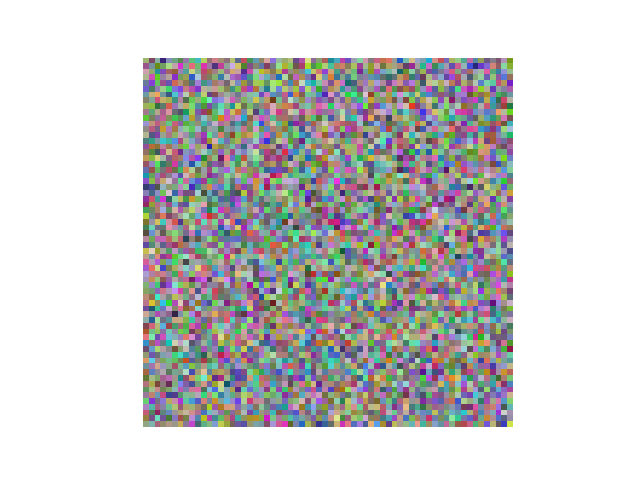

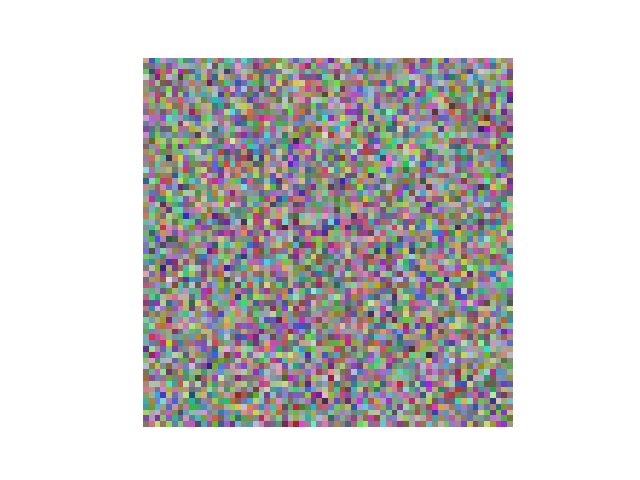

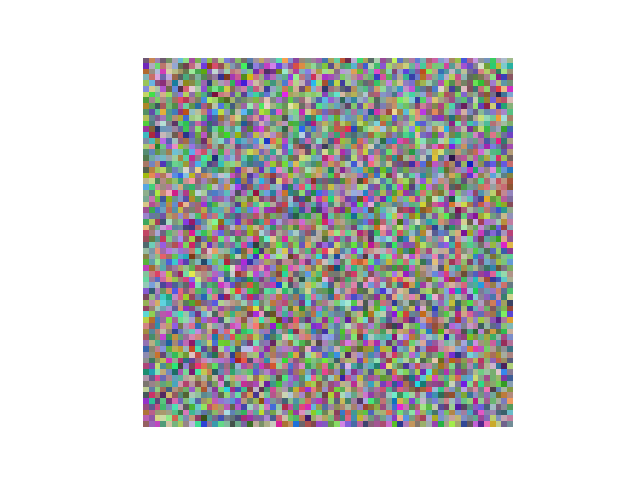

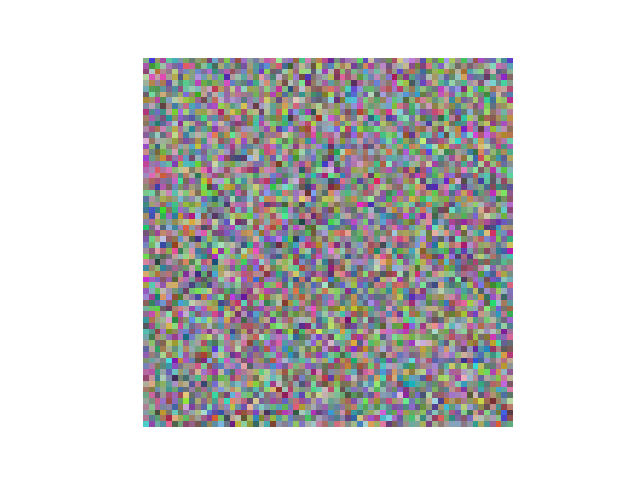

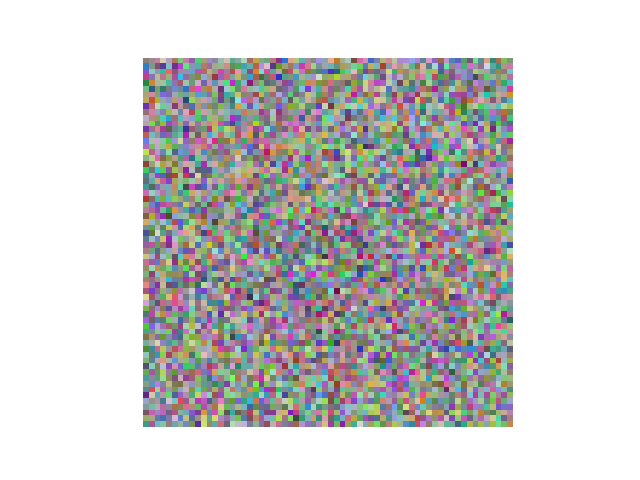

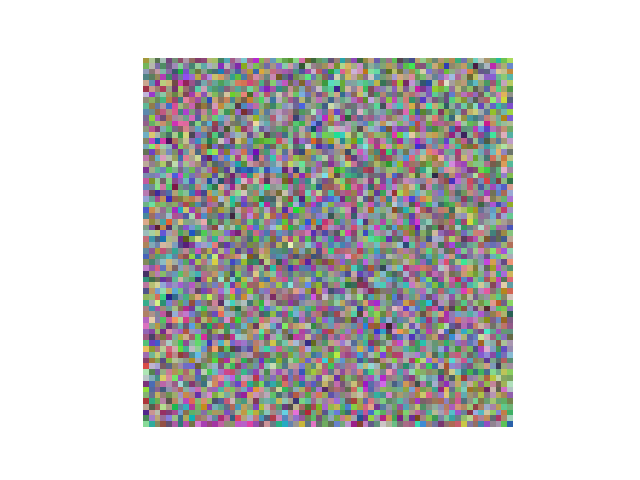

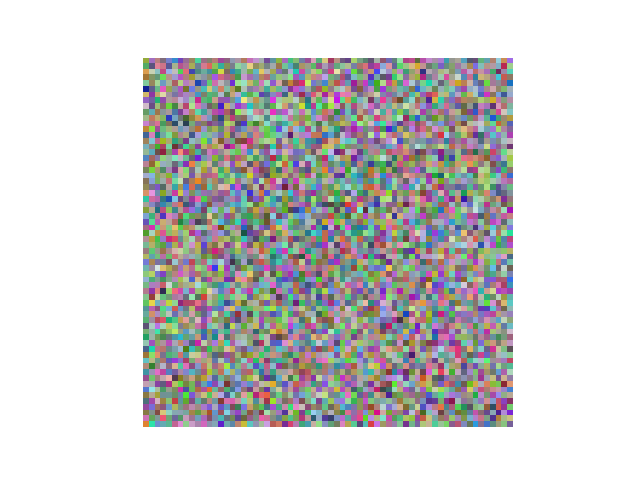

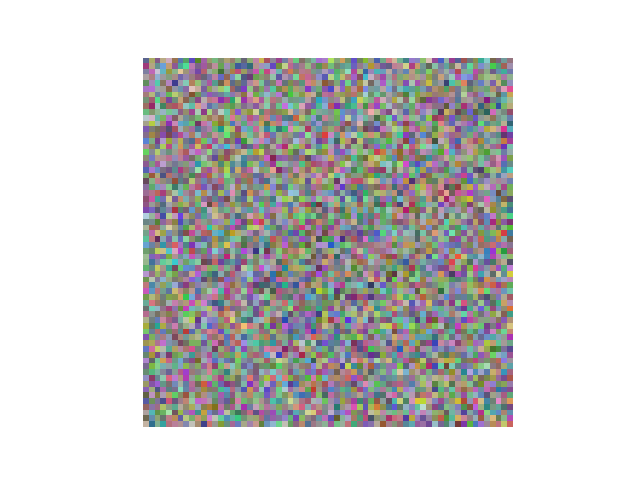

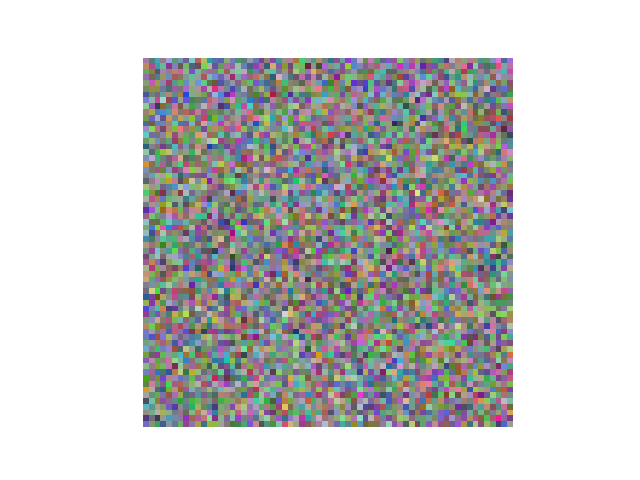

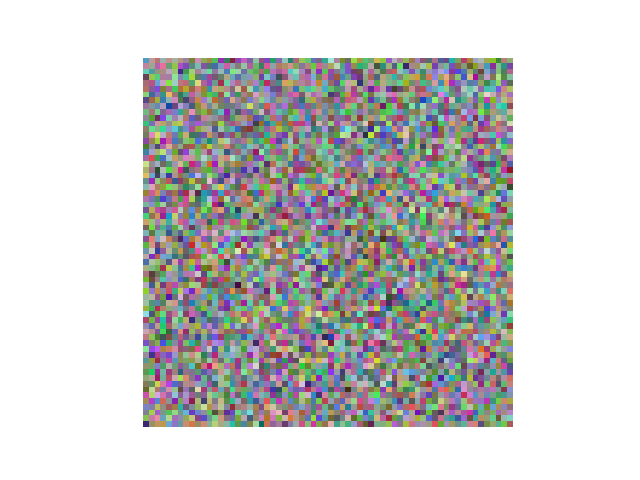

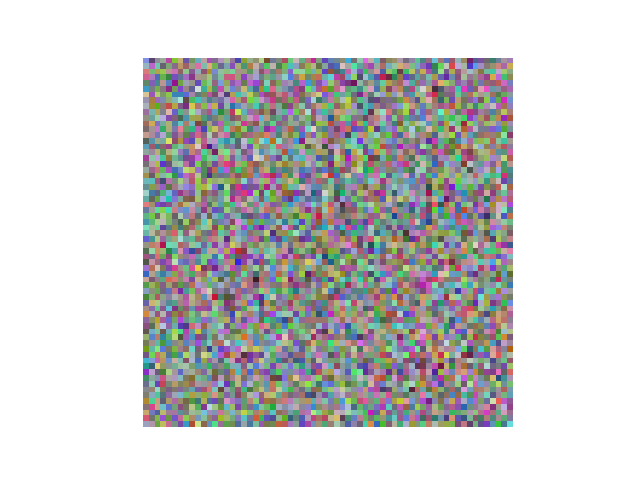

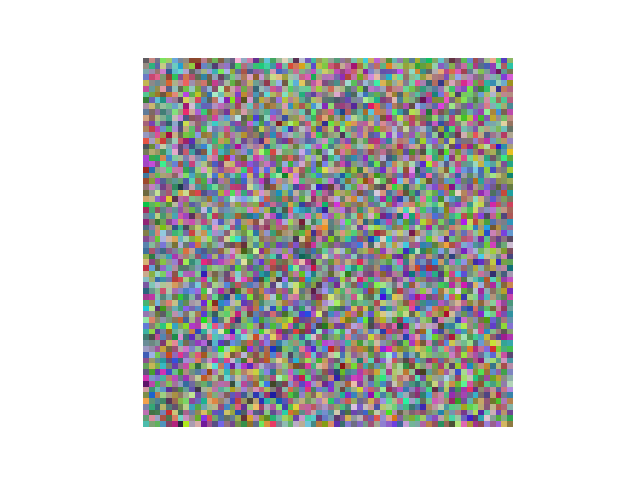

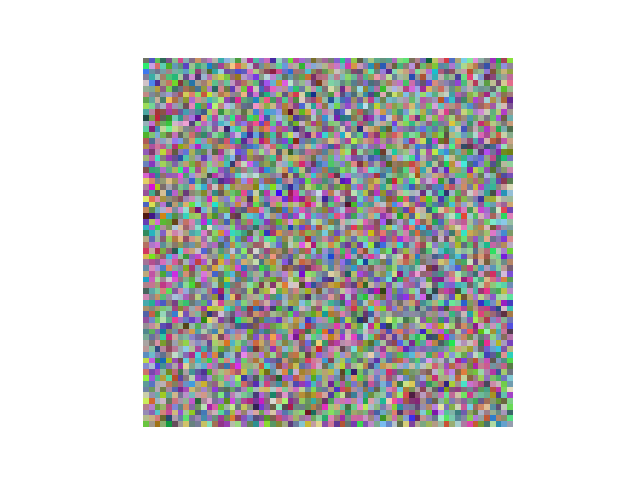

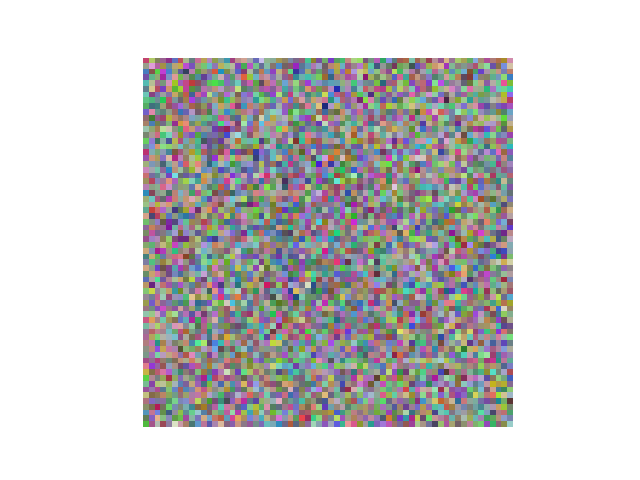

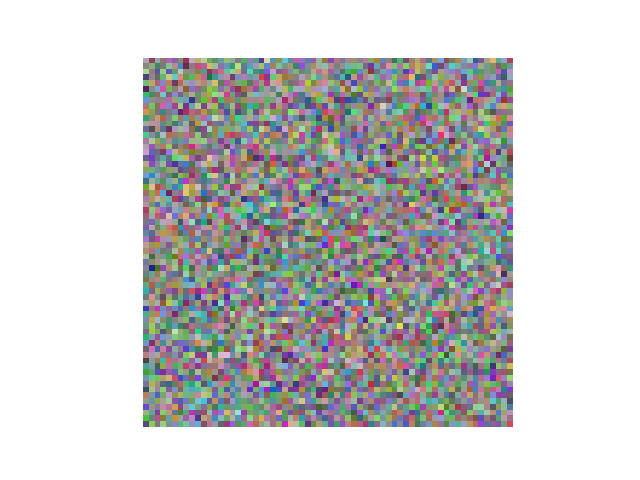

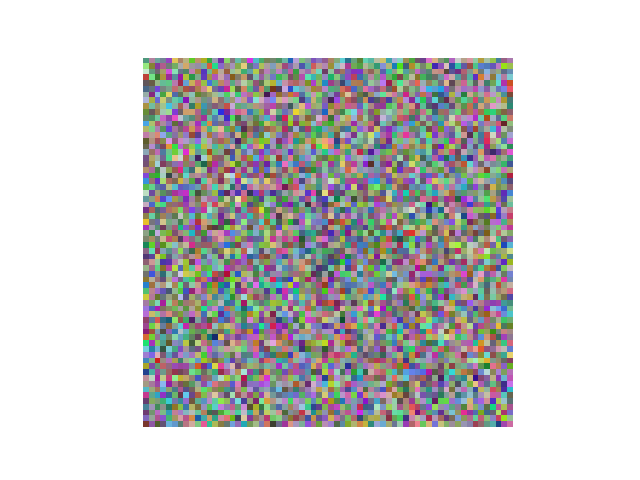

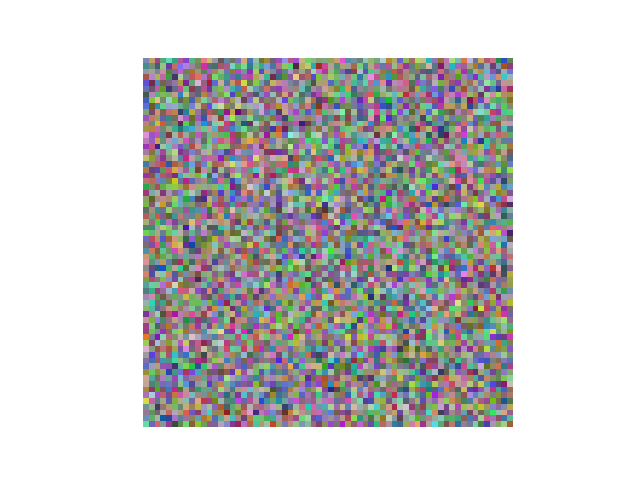

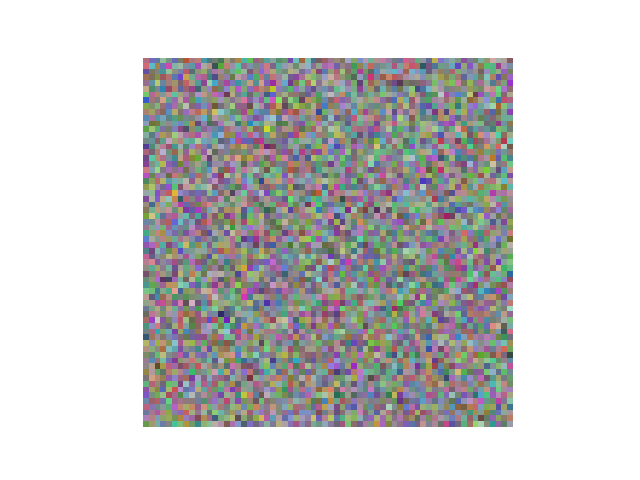

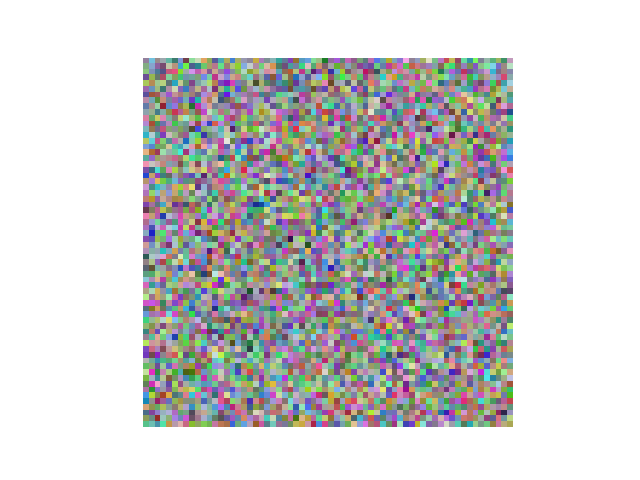

In [13]:
from IPython.display import Image, display
import os

# Directory where the generated images are saved
generated_image_dir = 'generated_images'

# List all image files in the directory
image_files = [f for f in os.listdir(generated_image_dir) if f.endswith('.png')]

# Display the generated images
for image_file in image_files:
    image_path = os.path.join(generated_image_dir, image_file)
    display(Image(filename=image_path))


Found 11344 images belonging to 1 classes.


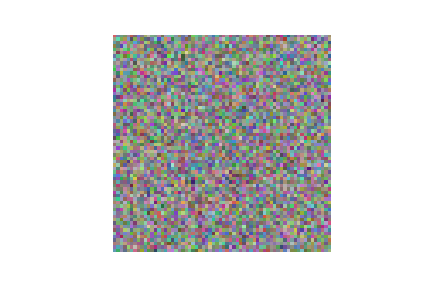

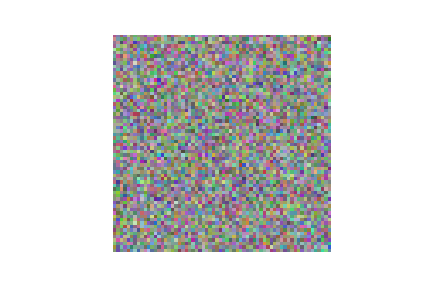

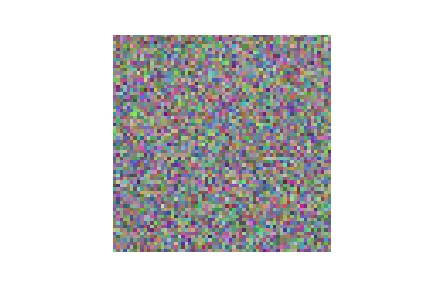

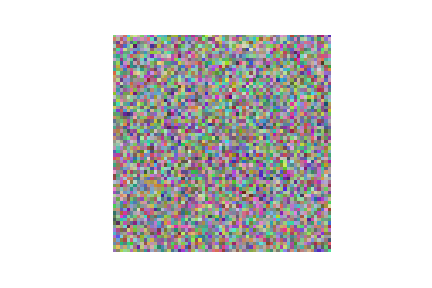

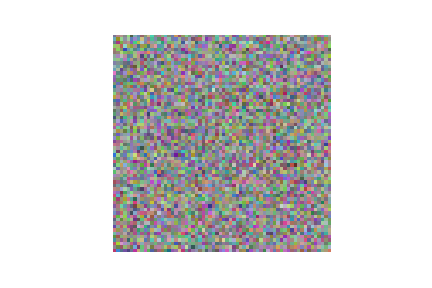

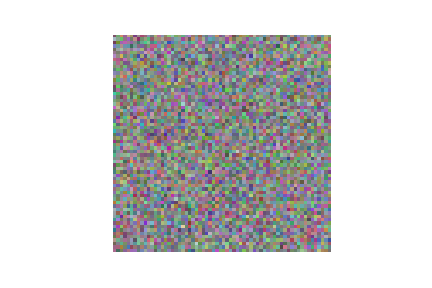

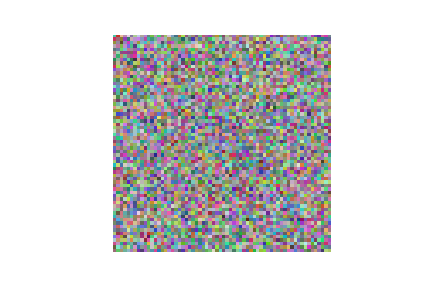

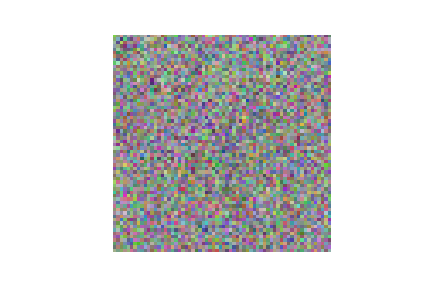

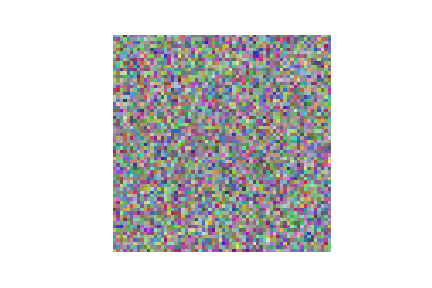

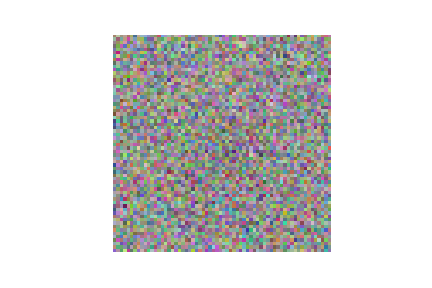

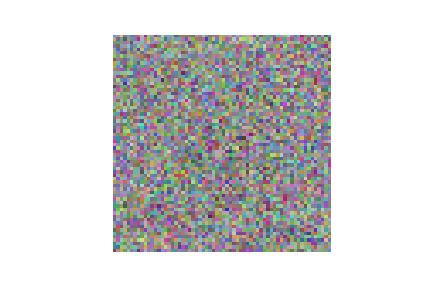

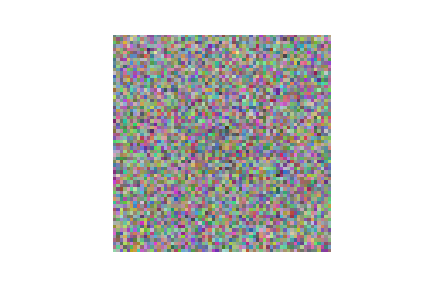

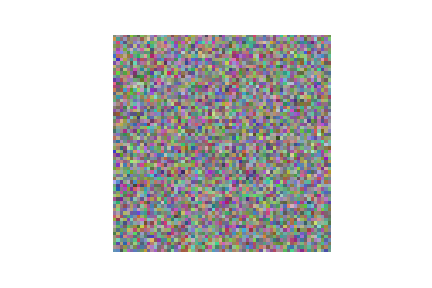

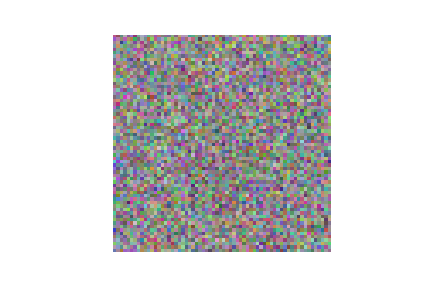

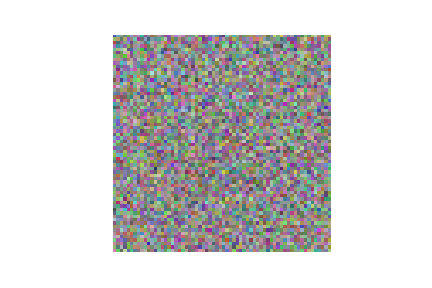

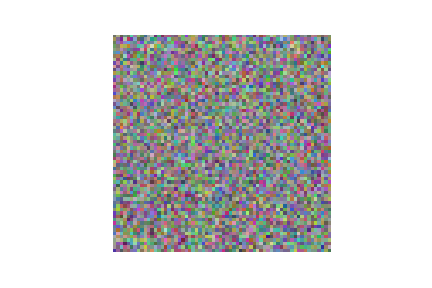

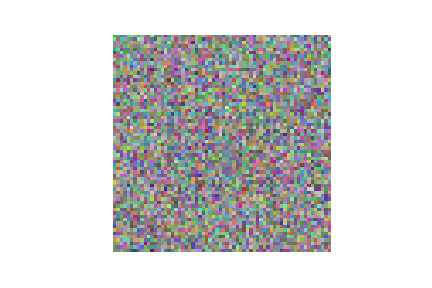

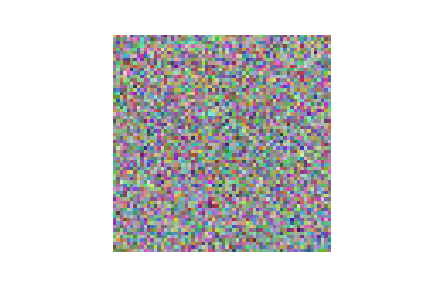

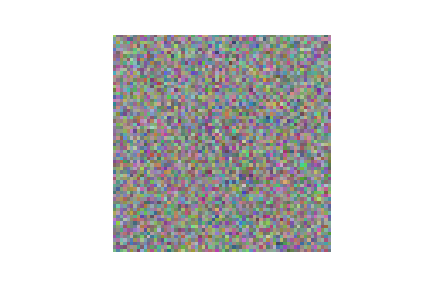

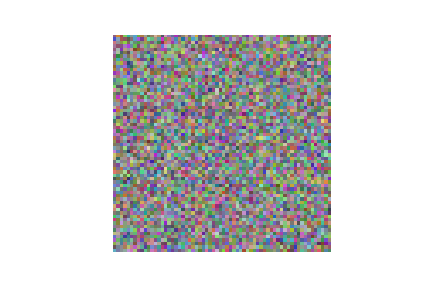

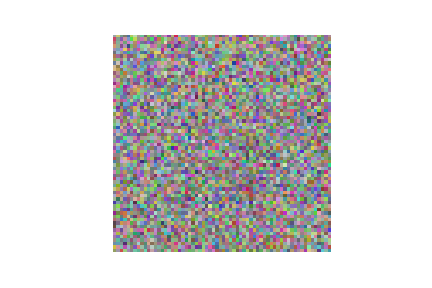

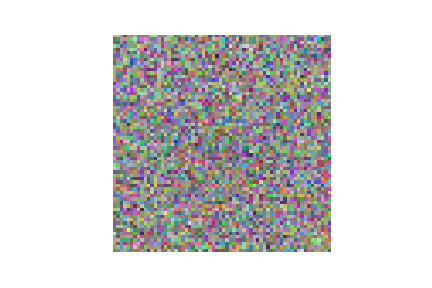

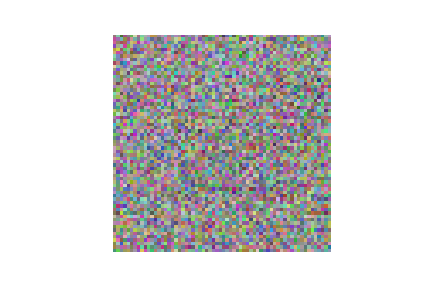

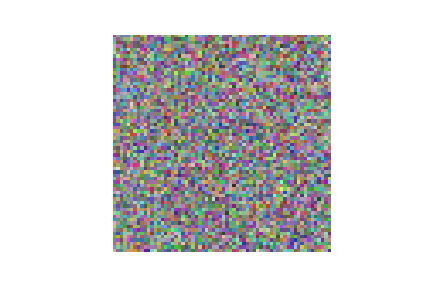

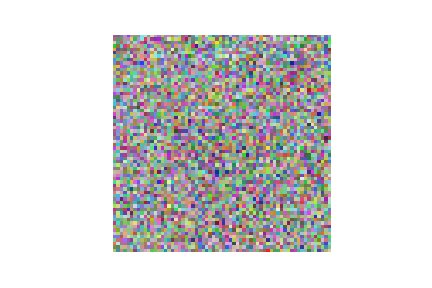

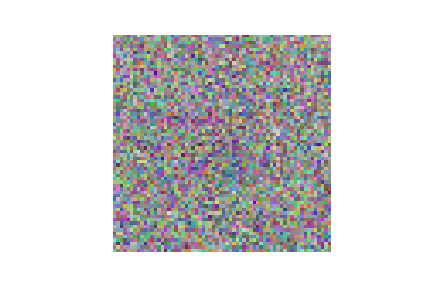

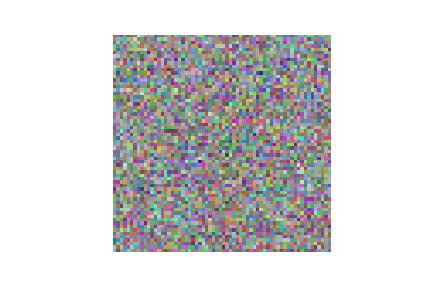

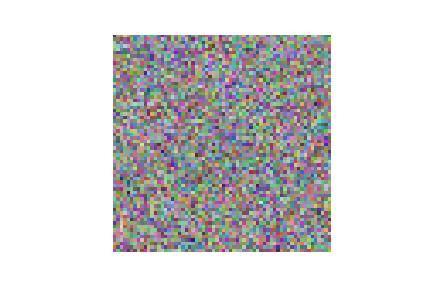

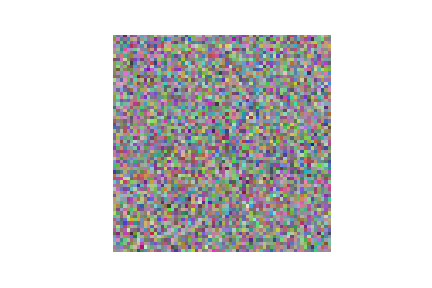

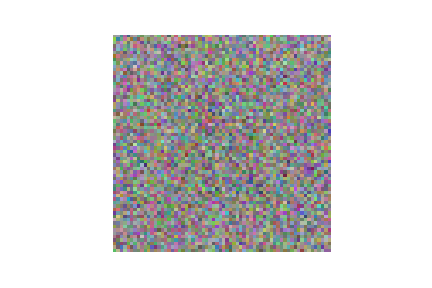

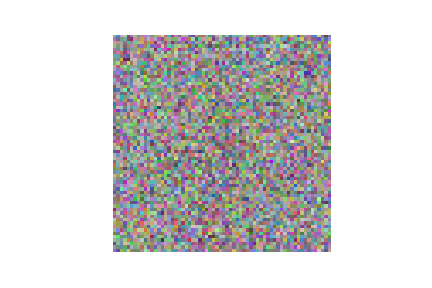

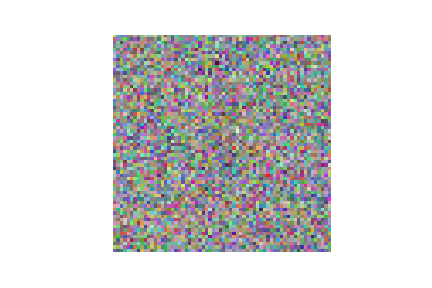

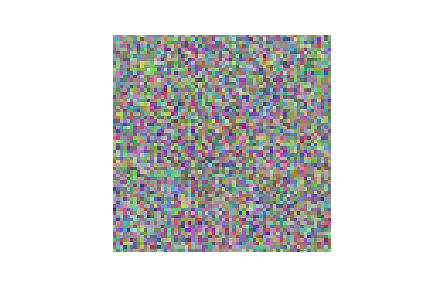

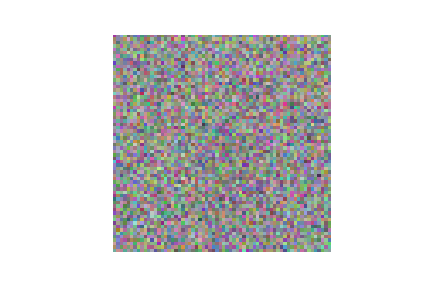

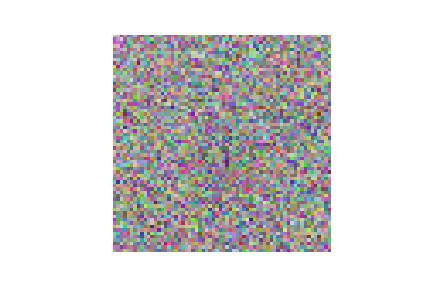

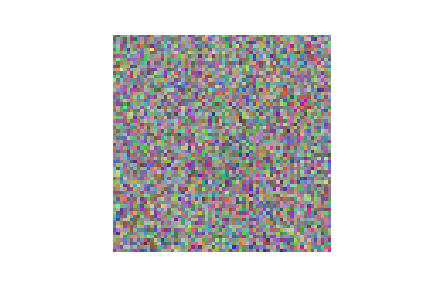

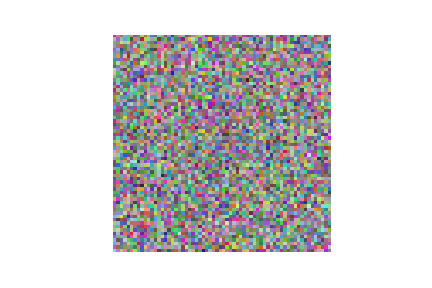

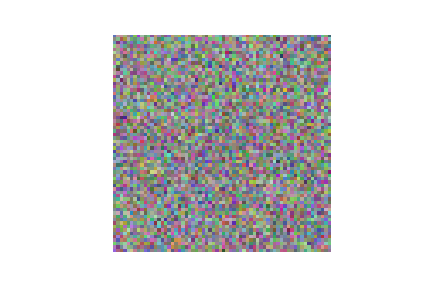

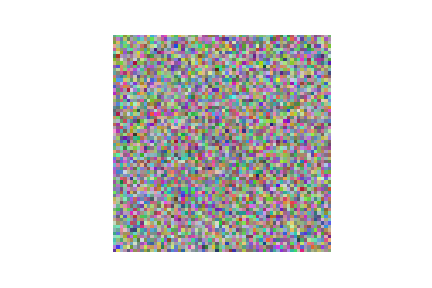

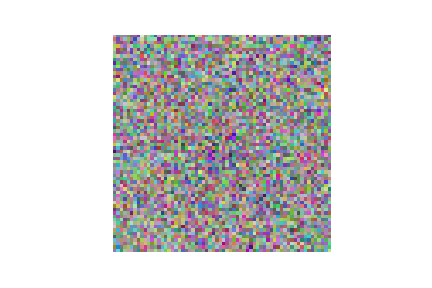

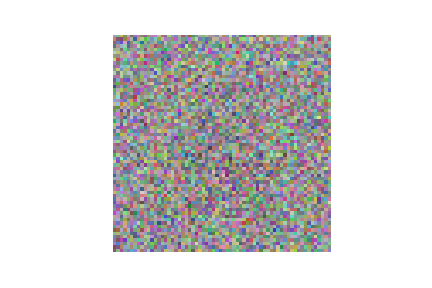

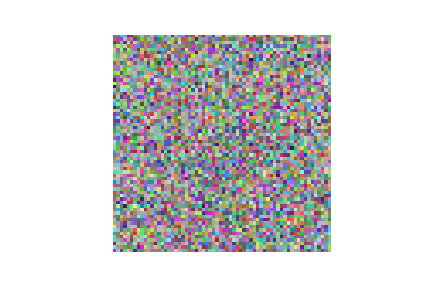

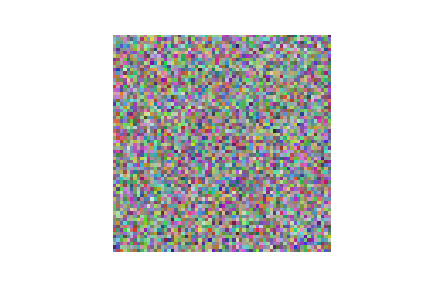

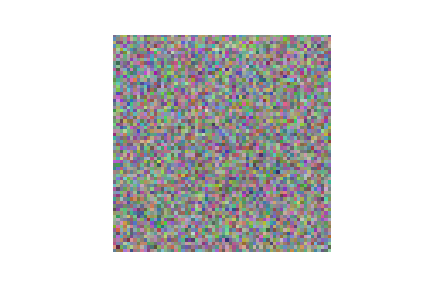

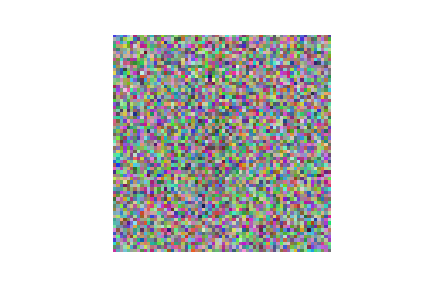

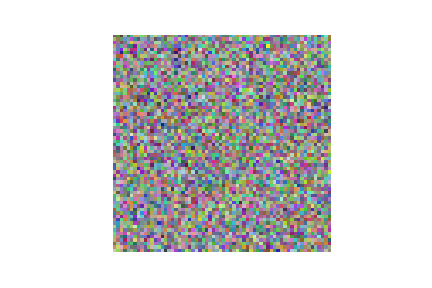

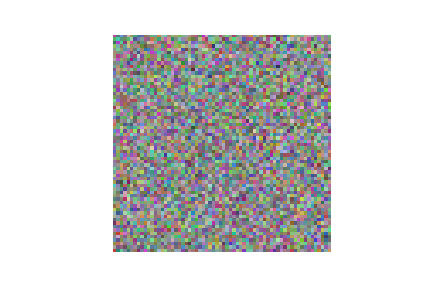

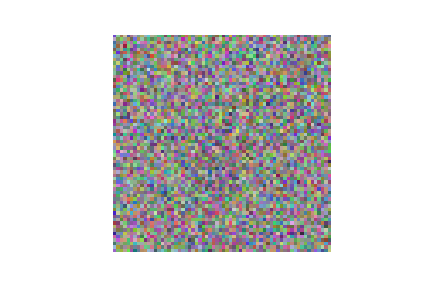

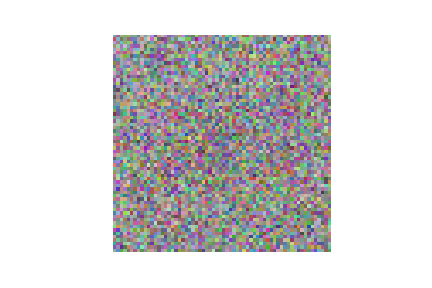

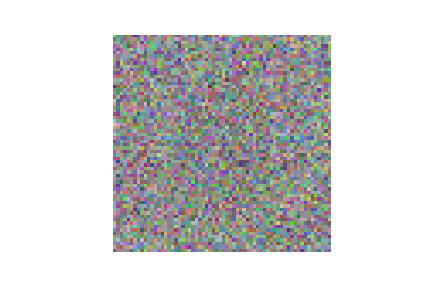

<Figure size 432x288 with 0 Axes>

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Set the path to the directory containing your labeled yoga pose images
image_dir = 'yoga_model'

# Define the dimensions for the images
img_width, img_height = 64, 64

# Define the number of classes (yoga poses)
num_classes = 10

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    data_format='channels_last',
)

# Load and preprocess images from the specified directory with class labels
image_data = datagen.flow_from_directory(
    image_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # This is for multi-class classification
    shuffle=True,
)

# Define the Generator model architecture
def build_generator():
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([noise_input, label_input])
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(img_width * img_height * 3, activation='tanh')(x)
    generated_image = Reshape((img_width, img_height, 3))(x)
    return Model([noise_input, label_input], generated_image)

# Load just the weights of the generator
generator = build_generator()
generator.load_weights('your_generator_model.h5')

# Compile the generator manually
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and save images for specific pose labels
def generate_images_for_labels(num_images, labels):
    for label in labels:
        label_one_hot = np.zeros((num_images, num_classes))  # Modify the shape
        label_idx = class_labels.index(label)
        label_one_hot[:, label_idx] = 1  # Set the one-hot encoding for the specified label
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5  # Scale back to [0, 1]

        for i in range(num_images):
            img = generated_images[i]
            plt.imshow(img)
            plt.axis('off')
            plt.savefig(f'generated_images/{label}_{i + 1}.png')
            plt.clf()  # Clear the plot for the next image

# Generate and save images for specific pose labels
generate_images_for_labels(num_images_to_generate, class_labels)

# Directory where the generated images are saved
generated_image_dir = 'generated_images'

# List all image files in the directory
image_files = [f for f in os.listdir(generated_image_dir) if f.endswith('.png')]

# Display the generated images
for image_file in image_files:
    image_path = os.path.join(generated_image_dir, image_file)
    display(Image(filename=image_path))


TypeError: Invalid shape (64, 64, 6) for image data

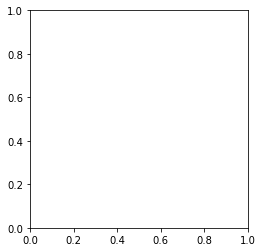

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the dimensions for the images
img_width, img_height = 64, 64

# Define the number of classes (yoga poses)
num_classes = 10

# Define the Generator model architecture
def build_generator():
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([noise_input, label_input])
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(2048)(x)  # Adding more layers
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(img_width * img_height * 6, activation='tanh')(x)  # Adjusting the units
    generated_image = Reshape((img_width, img_height, 6))(x)  # Adjusting the reshape dimensions
    return Model([noise_input, label_input], generated_image)

# Load the trained generator model
generator = build_generator()

# Compile the generator manually
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Save the trained generator model
generator.save('your_generator_model.h5')

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and save images for specific pose labels
def generate_images_for_labels(num_images, labels):
    for label in labels:
        label_one_hot = np.zeros((num_images, num_classes))  # Modify the shape
        label_idx = class_labels.index(label)
        label_one_hot[:, label_idx] = 1  # Set the one-hot encoding for the specified label
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5  # Scale back to [0, 1]

        for i in range(num_images):
            img = generated_images[i]
            plt.imshow(img)
            plt.axis('off')
            plt.savefig(f'generated_images/{label}_{i + 1}.png')
            plt.clf()  # Clear the plot for the next image

# Generate and save images for specific pose labels
generate_images_for_labels(num_images_to_generate, class_labels)


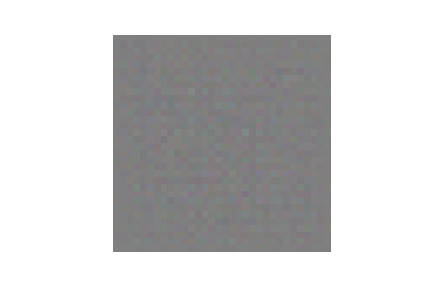

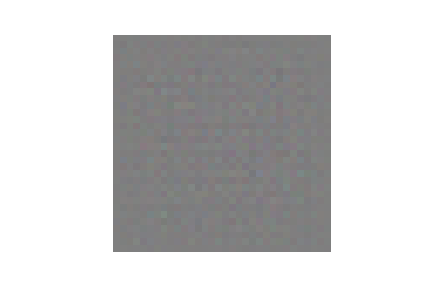

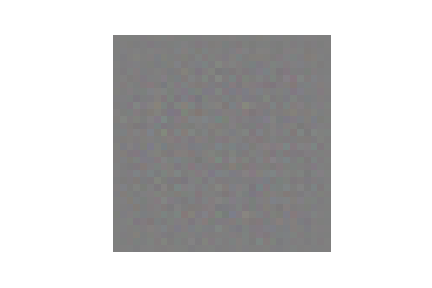

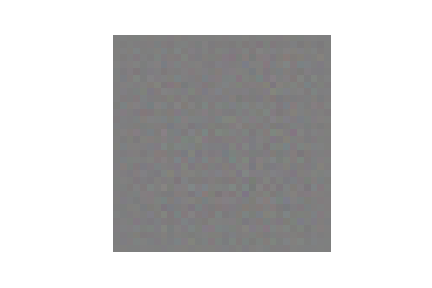

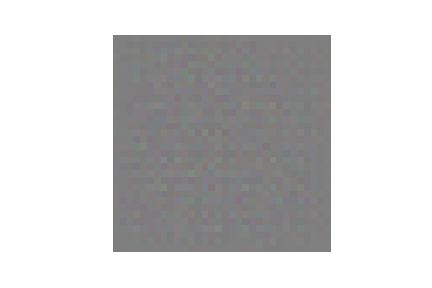

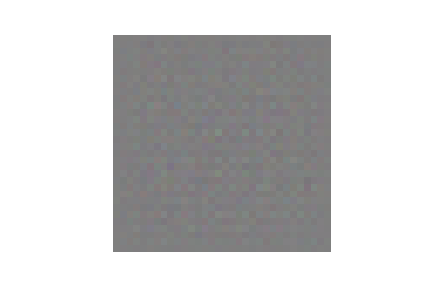

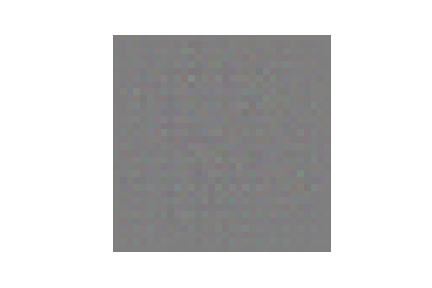

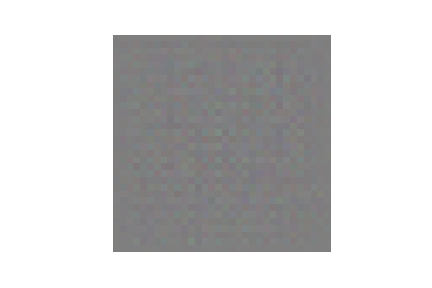

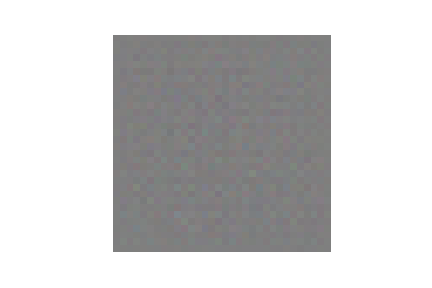

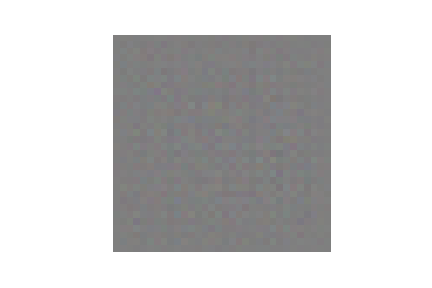

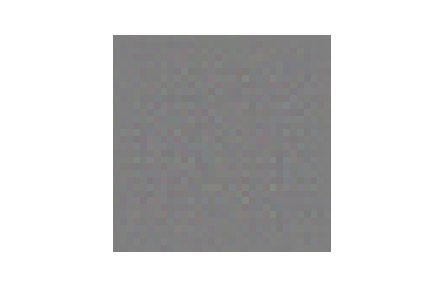

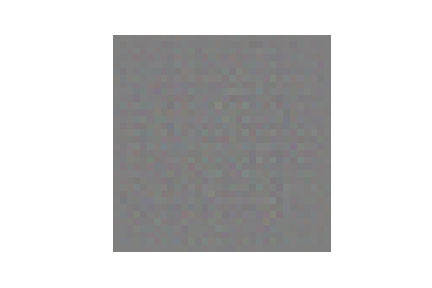

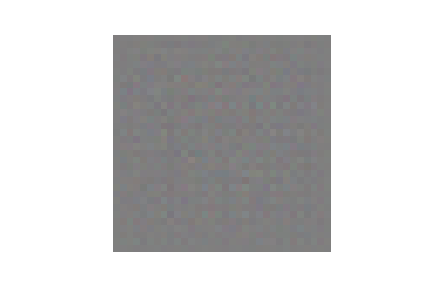

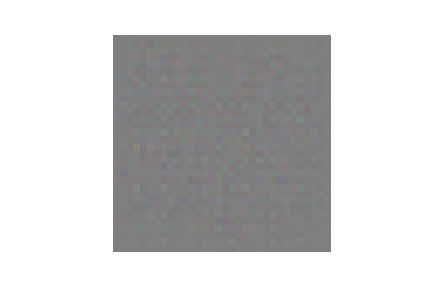

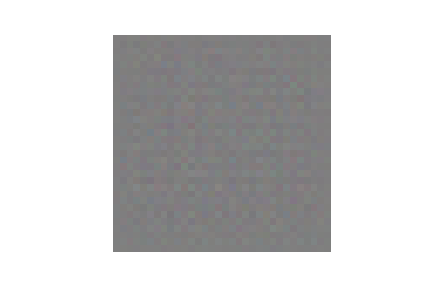

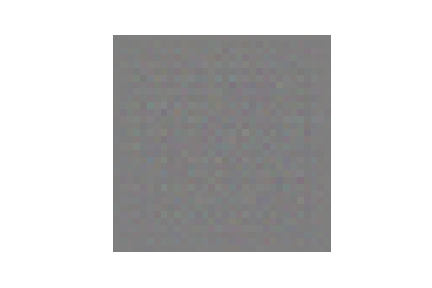

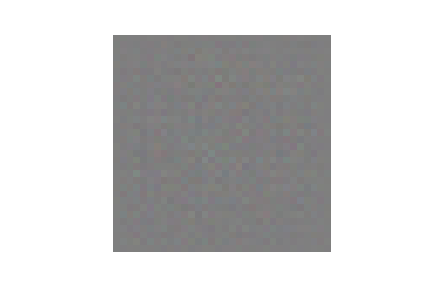

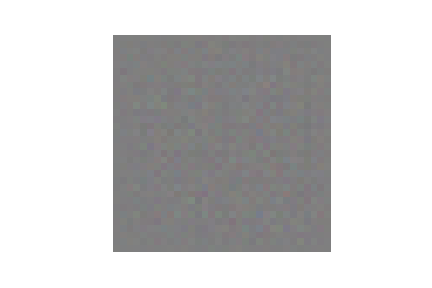

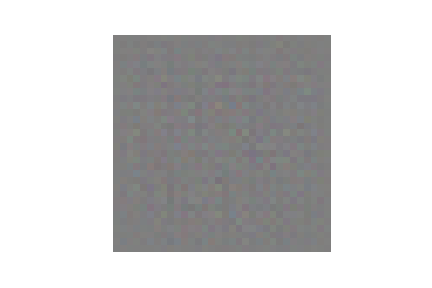

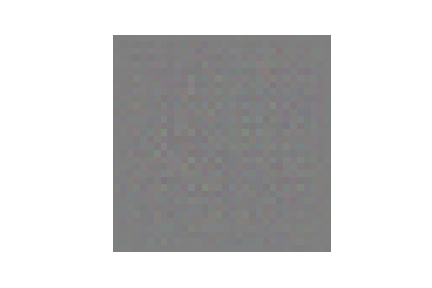

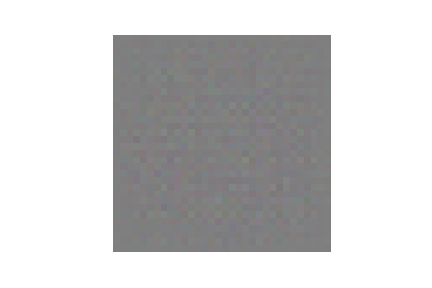

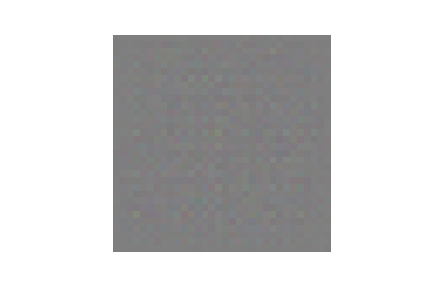

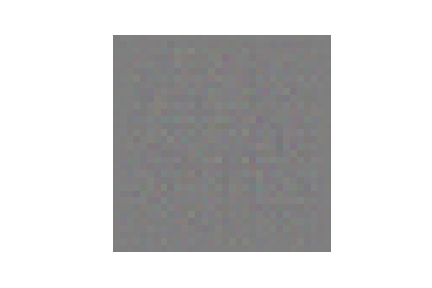

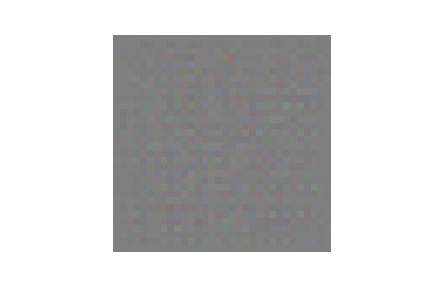

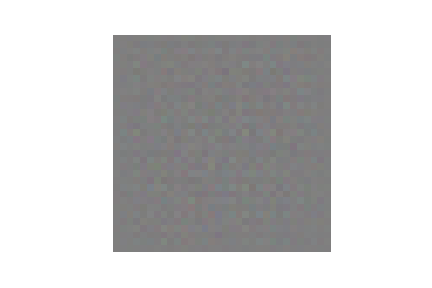

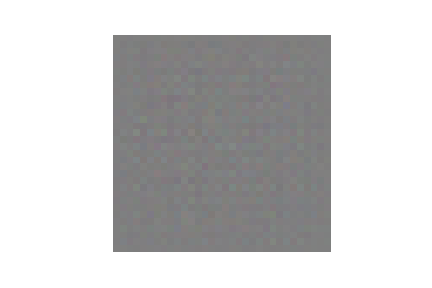

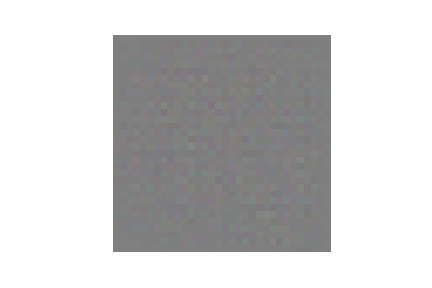

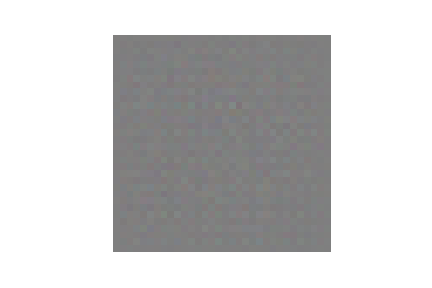

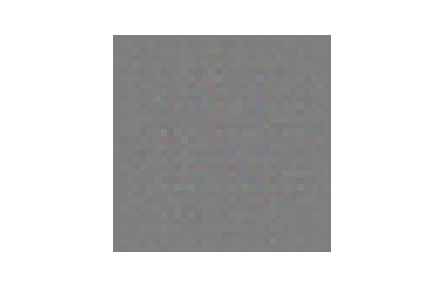

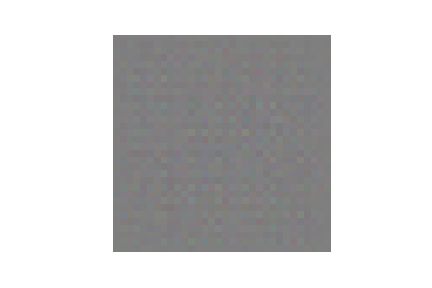

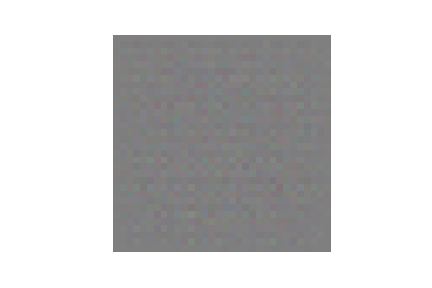

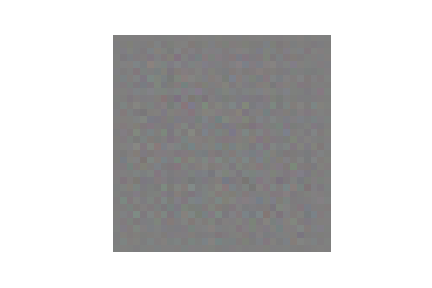

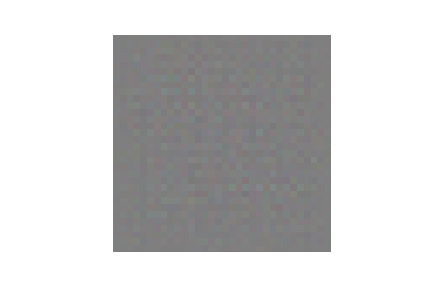

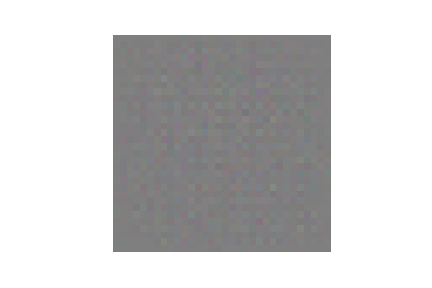

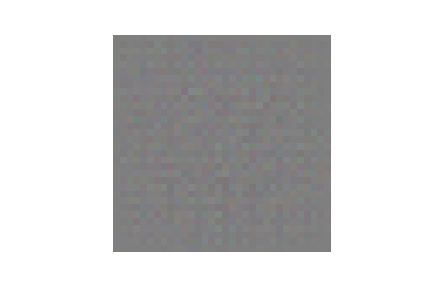

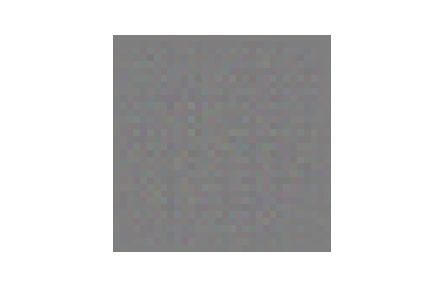

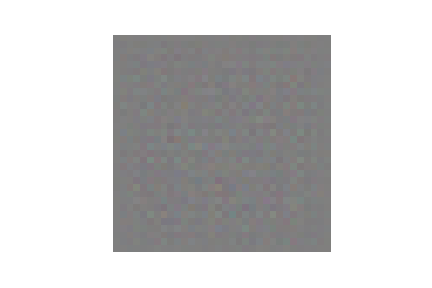

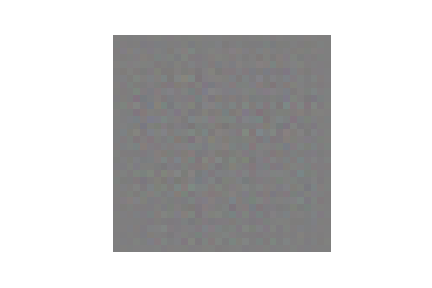

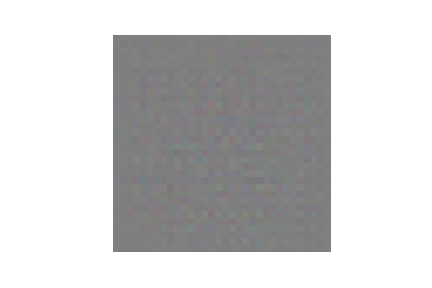

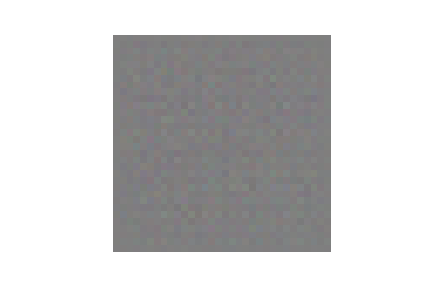

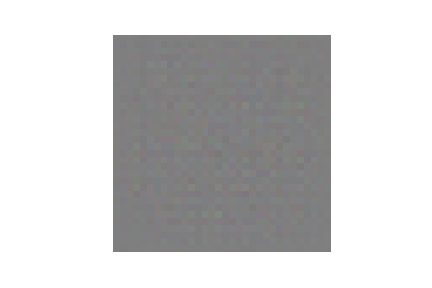

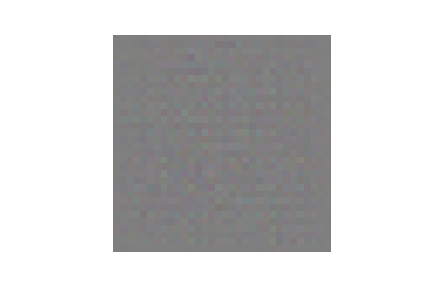

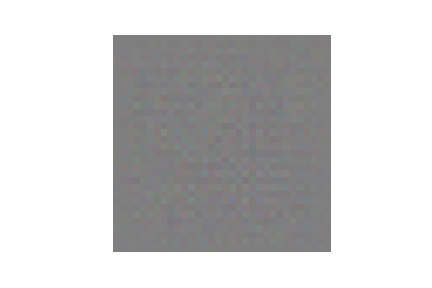

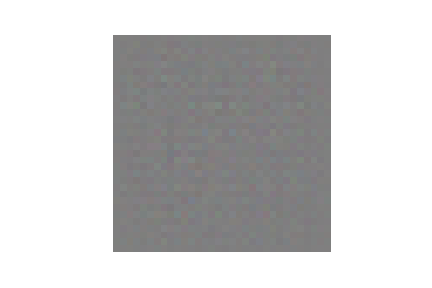

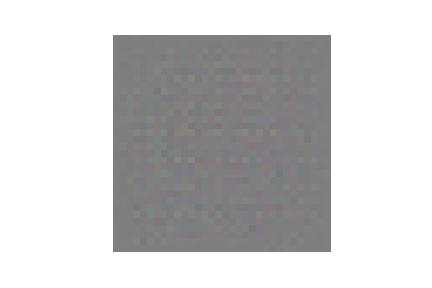

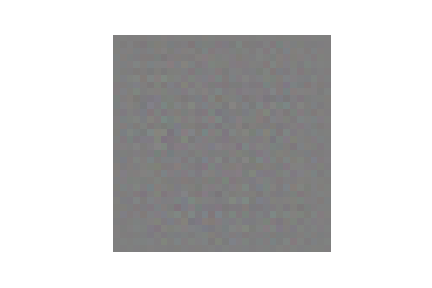

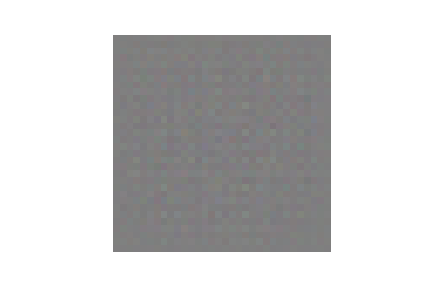

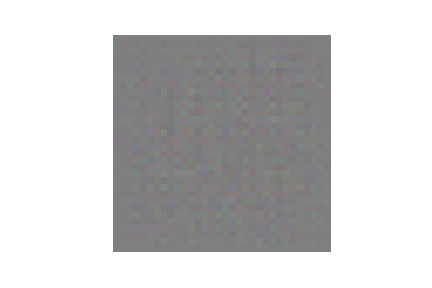

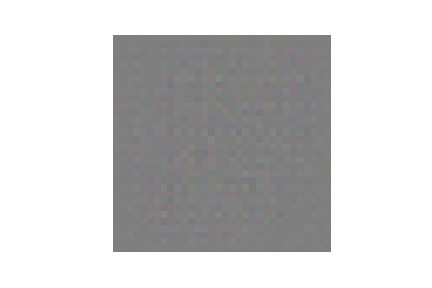

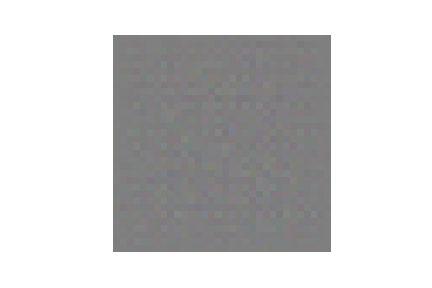

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Set the path to the directory containing your labeled yoga pose images
image_dir = 'yoga_model'

# Define the dimensions for the images
img_width, img_height = 64, 64

# Define the number of classes (yoga poses)
num_classes = 10

# Define the Generator model architecture
# Define the Generator model architecture
def build_generator():
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([noise_input, label_input])
    x = Dense(256 * 4 * 4)(x)
    x = Reshape((4, 4, 256))(x)
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)
    return Model([noise_input, label_input], x)

# Load the trained generator model
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and save images for specific pose labels
def generate_images_for_labels(num_images, labels):
    for label in labels:
        label_one_hot = np.zeros((num_images, num_classes))
        label_idx = class_labels.index(label)
        label_one_hot[:, label_idx] = 1
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5

        for i in range(num_images):
            img = generated_images[i]
            plt.imshow(img)
            plt.axis('off')
            plt.savefig(f'generated_images/{label}_{i + 1}.png')
            plt.close()  # Close the figure after saving

# Generate and save images for specific pose labels
generate_images_for_labels(num_images_to_generate, class_labels)

# Directory where the generated images are saved
generated_image_dir = 'generated_images'

# List all image files in the directory
image_files = [f for f in os.listdir(generated_image_dir) if f.endswith('.png')]

# Display the generated images
for image_file in image_files:
    image_path = os.path.join(generated_image_dir, image_file)
    display(Image(filename=image_path))


In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Set the path to the directory containing your labeled yoga pose images
image_dir = 'yoga_model'

# Define the dimensions for the images
img_width, img_height = 64, 64

# Define the number of classes (yoga poses)
num_classes = 10

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    data_format='channels_last',
    rotation_range=20,  # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    shear_range=0.2,  # Shear intensity (in radians)
    zoom_range=0.2,  # Zoom range [1 - zoom_range, 1 + zoom_range]
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Load and preprocess images from the specified directory with class labels
image_data = datagen.flow_from_directory(
    image_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # This is for multi-class classification
    shuffle=True,
)

# Define the Generator model architecture
def build_generator():
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(num_classes,))
    x = Concatenate()([noise_input, label_input])
    x = Dense(256 * 8 * 8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((8, 8, 256))(x)
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)
    generated_image = x
    return Model([noise_input, label_input], generated_image)

# Load the trained generator model
generator = build_generator()

# Compile the generator manually with Wasserstein loss and custom learning rate
optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
generator.compile(loss='wasserstein_loss', optimizer=optimizer)

# Define the number of images to generate for each pose label
num_images_to_generate = 5  # Adjust this as needed

# Define the class labels (yoga poses) based on the images
class_labels = [
    'Anantasana', 'Ardhakati Chakrasana', 'Bhujangasana', 'Kati Chakrasana', 'Marjariasana',
    'Parvatasana', 'Sarvangasana', 'Tadasana', 'Vajrasana', 'Viparita Karani'
]

# Create a directory to save generated images (if it doesn't exist)
os.makedirs('generated_images', exist_ok=True)

# Function to generate and save images for specific pose labels
def generate_images_for_labels(num_images, labels):
    for label in labels:
        label_one_hot = np.zeros((num_images, num_classes))
        label_idx = class_labels.index(label)
        label_one_hot[:, label_idx] = 1
        noise = np.random.normal(0, 1, (num_images, 100))

        generated_images = generator.predict([noise, label_one_hot])
        generated_images = 0.5 * generated_images + 0.5

        for i in range(num_images):
            img = generated_images[i]
            plt.imshow(img)
            plt.axis('off')
            plt.savefig(f'generated_images/{label}_{i + 1}.png')
            plt.close()  # Close the figure after saving

# Generate and save images for specific pose labels
generate_images_for_labels(num_images_to_generate, class_labels)


Found 11344 images belonging to 1 classes.
